<a name="top"> <h1>00.Data Reading and Preparation</h1> <a>

<p>Geospatial Analysis of the 2023 Earthquakes in Turkey<br />
<strong>Master Thesis</strong><br />
<strong>Master of Data Science</strong></p>


<p style="text-align:right">Gozde Yazganoglu (<em>gozde.yazganoglu@cunef.edu</em>)</p>

[Introduction](#Introduction) 

[1. Importing Packages and Functions](#librerias) 



# Introduction

On 6 February 2023, a devastating Mw 7.8 earthquake hit southern and central Turkiye and northern and western Syria, followed by a Mw 7.7 earthquake. These were the largest seismic events in Turkiye since the 1939 Erzincan earthquake and among the strongest ever recorded in the Levant. The tremors were felt as far as Egypt and the Black Sea coast of Turkiye, with over 30,000 aftershocks recorded in the following three months.

The quakes resulted in widespread damage across an area of about 350,000 km2, affecting approximately 16 percent of Turkiye's population or an estimated 14 million people. About 1.5 million people were rendered homeless according to United Nations development experts.

The confirmed death toll was 59,259, with 50,783 deaths in Turkiye and 8,476 in Syria, making it the deadliest natural disaster in Turkiye's modern history and the deadliest in present-day Syria since the 1822 Aleppo earthquake. These were also the deadliest worldwide since the 2010 Haiti earthquake and the fifth-deadliest of the 21st century. The damage was estimated at US$104 billion in Turkiye and US$14.8 billion in Syria, ranking them as the fourth-costliest earthquakes on record.

The rescue and relief efforts were significantly hampered by damaged roads, winter storms, and communication disruptions. Despite the challenges, a rescue force of 60,000, 5,000 health workers, and 30,000 volunteers were deployed. In response to Turkiye's call for international assistance, more than 141,000 people from 94 countries joined the rescue effort.

Source : https://en.wikipedia.org/wiki/2023_Turkey%E2%80%93Syria_earthquake 

The economic losses have necessitated reconstruction or reinforcement of the affected area. It's crucial for businesses and political leaders to remember that this reconstruction involves a societal aspect - the city must be rebuilt in accordance with its specific economic and societal necessities. Moreover, as the hazard remains persistent, we must factor in existing risks, which could potentially open up future business opportunities. Hence, this issue should be given significant business consideration. Consequently, in this study, I have opted to investigate the condition of the buildings, facilities, and roads within the region.

In this notebook we are going to examine the dataset Copernicus EU Disaster data from satelites. We are taking the data from kaggle. Dataset has several information and it is not unitary for all locations. because of this reason, instead of examining this data set, we are going to check individually in locations and later we are going to merge all in a big data set.
Source : https://www.kaggle.com/datasets/brsdincer/feb-06-23earthquake-turkey-citiesvectors
Main Source : https://emergency.copernicus.eu/mapping/download/201003/Report_EMSR648_Earthquake_T%C3%BCrkiye_20230213.pdf?redirect=list-of-components/EMSR648/GRADING/ALL 


To have more information we are also going to take information devived from Turkstat databank (variables as popiulation, income, house sales...etc) and we will use AFAD data about 
Source: https://www.kaggle.com/datasets/ardaorcun/turkey-6-february-disaster-and-related-datas

Main Sources:
For earthquakes: https://deprem.afad.gov.tr/event-catalog
For any data about population and economic numbers: https://www.tuik.gov.tr/

Finally we also used also general fault information to understand the relationship of aproximity to the dangerous zones.

https://atag.itu.edu.tr/v4/?p=135




# Importing Libraries and Functions

In this notebook the dataset of our interest will be constructed in detailed operations.For this we need pandas/geopandas to manipulate geodata.


In [78]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import os
import contextily as ctx
import pickle
import numpy as np
from shapely.ops import nearest_points



In this notebook we are opening city vectors of the Copernicus disaster data. Data consist of several datasets and not unitary for all cities. For this reason instead of reading them in a on a fuction we are reading them individually. Below it is explaied which are the information we have in this dataset:

 * AncilliaryCrisisInfo : Locations of emergency meeting points
 * AreaofInterest : The unit ( city or province ) we are checking in this dataset.
 * Buildup : Buildings that we have the damage information.
 * Facilities : Facility buildings in the area
 * Hydrography : Water sources
 * Physiography : This datasets are consist of equal counter lines for the same level of height.
 * Thansportation : Roads in the area of interest. We also have damage information about roads.



Our target data of interest is the level of damage. Building, Facilities and Transportation items have this info and these datasets have more or less the same variables whis allows to be concataneted.
Area of interest information is necessary to differentiate and check whether there are different effects in different areas.

Elevation level, aproximity to the water are other geographic properties that might be interesting in this study. These factors has affect on quality of the zone. Most of the studies show that hard zones keep the building more strong. Meantime, we keep in to account that zone properties can differ in different places for the same building as well.

Another interesting datasets we observ in this data group is AncilliaryCrisisInfo data. If a zone is expecting a danger, or in case of other emergencies, exterior meeting points are very important. These zones can provide temporary shelter till danger is gone. It can be an important variable to define dangerous zones.  

## Areas of Interes at a glance and constructing local data.

    
     1.Adiyaman: 

     As in the other cities and provinces we are going to have a look, province of Adiyaman is located in the southeast of Anatolia region and were highly effected/damaged by the earthquakes in february.

https://en.wikipedia.org/wiki/Ad%C4%B1yaman

In [2]:
#paths
# ancillary data for Adiyaman
path_adiyaman_anc = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'
path_adiyaman_anc2 = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
# area of interest in Polygon
path_adiyaman_area = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
# Water resources
path_adiyaman_hydro= '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_hydrographyL_r1_v1.shp'

#Counterlines data
path_adiyaman_phisio= '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_physiographyL_r1_v1.shp'
#data for transportation
path_adiyaman_transportation= '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_transportationL_r1_v1.shp'

# facilities in the region
path_adiyaman_f = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_facilitiesA_r1_v1.shp'

#buildings in the region
path_adiyaman_b = '../data/vectors/ADIYAMAN/M1_V1/EMSR648_AOI02_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI02_GRA_MONIT01_builtUpA_r1_v1.shp'                 

# merging datasets of the facilities, buildings and transportation for Adiyaman
data_built= pd.concat ([gpd.read_file(path_adiyaman_b),gpd.read_file(path_adiyaman_b), gpd.read_file(path_adiyaman_transportation)])


#merging building dataset with area of interest so that we can kee this information in the data as well. Spatial joint is used for this purpose. Normal merge is not working for geopandas dataframes.
data_adiyaman = data_built.sjoin(gpd.read_file(path_adiyaman_area), how='inner', op='within')


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


For every region some socioeconomic data of interest is gathered from TURKSTAT website, geographic infotmation system. These variables might be useful in the results to understand business opportunties.

Source: https://cip.tuik.gov.tr/

In [3]:
#adding population of last year and income in USD 
data_adiyaman['population'], data_adiyaman['income'] = 316140, 4092
#total and second hand sales in the municipality in the last five years
data_adiyaman['total_sales'], data_adiyaman['second_sales'] =  40087 ,20574
# percentage of accecing clean city water in the province
data_adiyaman['water_access']= 0.98
#electric consumption of per capita
data_adiyaman['elec_cons']= 2060
#number of buildings permited
data_adiyaman['building_perm']= 810
#m2 of the land permited for construction
data_adiyaman['land_permited'] = 695718
#labour force participation and unemployment rate in the province
data_adiyaman['labour_fource'] = 50
data_adiyaman['unemployment'] = 10.1

#agricultural area in decares
data_adiyaman['agricultural'] = 2336012
#expected lifetinme

data_adiyaman['life_time'] = 79.7
#number of hospitals and beds in the province per 100000 people
data_adiyaman['hb_per100000']= 222
#fertility rate in the province
data_adiyaman['fertility']= 2.36
#average household size
data_adiyaman['hh_size']= 4


obj_type     name                       info  \
0      11-Residential Buildings  Unknown         997-Not Applicable   
1      11-Residential Buildings  Unknown         997-Not Applicable   
2  12-Non-residential Buildings  Unknown  1251-Industrial buildings   
3  12-Non-residential Buildings  Unknown  1251-Industrial buildings   
4      11-Residential Buildings  Unknown         997-Not Applicable   

          damage_gra            det_method        notation  or_src_id  \
0  No visible damage  Photo-interpretation  Building block          1   
1  No visible damage  Photo-interpretation  Building block          1   
2  No visible damage  Photo-interpretation  Building block          1   
3  No visible damage  Photo-interpretation  Building block          1   
4  No visible damage  Photo-interpretation  Building block          1   

   dmg_src_id        cd_value            real  ... elec_cons  building_perm  \
0           3  Not Applicable  Not Applicable  ...      2060            810   
1           3  Not Applicable  Not Applicable  ...      2060            810   
2           3  Not Applicable  Not Applicable  ...      2060            810   
3           3  Not Applicable  Not Applicable  ...      2060            810   
4           3  Not Applicable  Not Applicable  ...      2060            810   

  land_permited labour_fource unemployment agricultural life_time  \
0        695718            50         10.1      2336012      79.7   
1        695718            50         10.1      2336012      79.7   
2        695718            50         10.1      2336012      79.7   
3        695718            50         10.1      2336012      79.7   
4        695718            50         10.1      2336012      79.7   

   hb_per100000  fertility  hh_size  
0           222       2.36        4  
1           222       2.36        4  
2           222       2.36        4  
3           222       2.36        4  
4           222       2.36        4  

[5 rows x 32 columns]

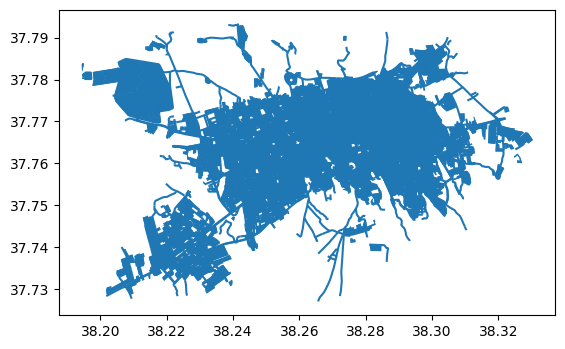

In [4]:

#ploting the geometry of the data
data_adiyaman.plot()

data_adiyaman.head()

    2. Afsin:

Afsin is a municipality located within the province of Kahramanmaras. The provided dataset, however, lacks ancillary details, facilities and doesn't include information about contour lines either. 

In a similar vein, extra data is manually extracted and incorporated into the dataset.

Info: https://en.wikipedia.org/wiki/Af%C5%9Fin


In [5]:

# building data
path_afsin = '../data/vectors/AFSIN/V1/EMSR648_AOI19_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI19_GRA_PRODUCT_builtUpP_r1_v1.shp'
# transportation data for AFSIN
path_afsin_transportation = '../data/vectors/AFSIN/V1/EMSR648_AOI19_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI19_GRA_PRODUCT_transportationL_r1_v1.shp'

# area of interest
path_afsin_area = '../data/vectors/AFSIN/V1/EMSR648_AOI19_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI19_GRA_PRODUCT_areaOfInterestA_r1_v1.shp'

#merging data for AFSIN
data_afsin = pd.concat([gpd.read_file(path_afsin),gpd.read_file(path_afsin_transportation)]).sjoin(gpd.read_file(path_afsin_area), how='inner', op='within')

# hydrography data for AFSIN
path_afsin_hidro = '../data/vectors/AFSIN/V1/EMSR648_AOI19_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI19_GRA_PRODUCT_hydrographyL_r1_v1.shp'



/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
#adding population of last year and income in USD
data_afsin['population'], data_afsin['income'] = 316140, 5997
#total and second hand sales in the municipality in the last five years
data_afsin['total_sales'], data_afsin['second_sales'] =  8762, 3300

# percentage of accecing clean city water in the province
data_afsin['water_access']= 0.95
#electric consumption of per capita
data_afsin['elec_cons']= 4343
#number of buildings permited
data_afsin['building_perm']= 1528
#m2 of the land permited for construction in province
data_afsin['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_afsin['labour_fource'] = 48.1
data_afsin['unemployment'] = 17.1

#agricultural area in decares
data_afsin['agricultural'] = 3535085
#expected lifetinme
data_afsin['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_afsin['hb_per100000']= 256
#fertility rate in the province
data_afsin['fertility']= 1.99
#average household size
data_afsin['hh_size']= 3.68

obj_type     name                 info  \
0      11-Residential Buildings  Unknown   997-Not Applicable   
1      11-Residential Buildings  Unknown   997-Not Applicable   
2      11-Residential Buildings  Unknown   997-Not Applicable   
3  12-Non-residential Buildings  Unknown  1220-Administrative   
4      11-Residential Buildings  Unknown   997-Not Applicable   

         damage_gra            det_method        notation  or_src_id  \
0         Destroyed  Photo-interpretation  Building point          1   
1         Destroyed  Photo-interpretation  Building point          1   
2         Destroyed  Photo-interpretation  Building point          1   
3  Possibly damaged  Photo-interpretation  Building point          1   
4           Damaged  Photo-interpretation  Building point          1   

   dmg_src_id        cd_value                   geometry  ...  elec_cons  \
0           2  Not Applicable  POINT (36.91705 38.24359)  ...       4343   
1           2  Not Applicable  POINT (36.91666 38.24353)  ...       4343   
2           2  Not Applicable  POINT (36.91611 38.24367)  ...       4343   
3           2  Not Applicable  POINT (36.91519 38.24321)  ...       4343   
4           2  Not Applicable  POINT (36.91311 38.24515)  ...       4343   

  building_perm land_permited labour_fource unemployment agricultural  \
0          1528       2222311          48.1         17.1      3535085   
1          1528       2222311          48.1         17.1      3535085   
2          1528       2222311          48.1         17.1      3535085   
3          1528       2222311          48.1         17.1      3535085   
4          1528       2222311          48.1         17.1      3535085   

   life_time  hb_per100000  fertility  hh_size  
0       79.2           256       1.99     3.68  
1       79.2           256       1.99     3.68  
2       79.2           256       1.99     3.68  
3       79.2           256       1.99     3.68  
4       79.2           256       1.99     3.68  

[5 rows x 31 columns]

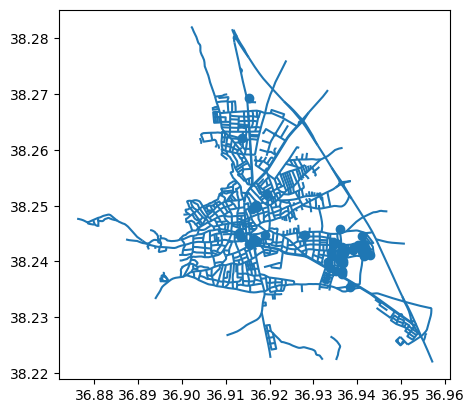

In [7]:
#to see representation of the data in map 
data_afsin.plot()

data_afsin.head()

    3. Antakya:

Antakya is the large municipal center of Hatay province close to Syrian border. In the area lives people with different etnicities and historically an inportant center for many religions. With the buildings that people lived many historical monuments reported to be destroyed.

Info: https://en.wikipedia.org/wiki/Antakya 



In [8]:
#ANTAKYA DATA

#Building dataset

path_antakya = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_builtUpA_r1_v2.shp'

#ancilary data
path_antakya_anc1 = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_ancillaryCrisisInfoA_r1_v2.shp'
path_antakya_anc2 = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_ancillaryCrisisInfoP_r1_v2.shp'

#water information
path_antakya_hidro = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_hydrographyL_r1_v2.shp'

#transportation
path_antakya_transportation = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_transportationL_r1_v2.shp'
#counter lines
path_antakya_phisio = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_physiographyL_r1_v2.shp'

#area of interest
path_antakya_area = '../data/vectors/ANTAKYA/M1_V2/EMSR648_AOI11_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI11_GRA_MONIT01_areaOfInterestA_r1_v2.shp'


#merging data set and joining spatially witht the area of interest using the within operation
data_antakya = pd.concat([gpd.read_file(path_antakya),gpd.read_file(path_antakya_transportation)]).sjoin(gpd.read_file(path_antakya_area), how='inner', op='within')


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
#Adding Additional statistical data for Antakya

#adding population of last year and income in USD
data_antakya['population'], data_antakya['income'] =  399045, 6785
#total and second hand sales in the municipality in the last five years
data_antakya['total_sales'], data_antakya['second_sales'] =  39858, 24992

# percentage of accecing clean city water in the province
data_antakya['water_access']= .99
#electric consumption of per capita
data_antakya['elec_cons']= 3984
#number of buildings permited
data_antakya['building_perm']= 1763
#m2 of the land permited for construction
data_antakya['land_permited'] =  2133640
#labour force participation and unemployment rate in the province
data_antakya['labour_fource'] = 48.1
data_antakya['unemployment'] = 17.1
#agricultural area in decares
data_antakya['agricultural'] = 353508523
#expected lifetinme
data_antakya['life_time'] = 77.9
#number of hospitals and beds in the province per 100000 people
data_antakya['hb_per100000']= 266
#fertility rate in the province
data_antakya['fertility']= 2.41
#average household size
data_antakya['hh_size']= 3.65

obj_type                   name  \
0  12-Non-residential Buildings   ÃzbuÄday Ortaokulu   
1  12-Non-residential Buildings     Hatay DoÄa Koleji   
3  12-Non-residential Buildings  Ãzel Defne Hastanesi   
4  12-Non-residential Buildings                Unknown   
5  12-Non-residential Buildings                Unknown   

                                             info         damage_gra  \
0  1263-School, university and research buildings  No visible damage   
1  1263-School, university and research buildings  No visible damage   
3   1264-Hospital or institutional care buildings  No visible damage   
4                                   1280-Cemetery  No visible damage   
5                                   1280-Cemetery  No visible damage   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building block        994           2   
1  Photo-interpretation  Building block        994           2   
3  Photo-interpretation  Building block        994           2   
4  Photo-interpretation  Building block        994           2   
5  Photo-interpretation  Building block        994           2   

         cd_value            real  ... elec_cons  building_perm land_permited  \
0  Not Applicable  Not Applicable  ...      3984           1763       2133640   
1  Not Applicable  Not Applicable  ...      3984           1763       2133640   
3  Not Applicable  Not Applicable  ...      3984           1763       2133640   
4  Not Applicable  Not Applicable  ...      3984           1763       2133640   
5  Not Applicable  Not Applicable  ...      3984           1763       2133640   

  labour_fource unemployment agricultural life_time  hb_per100000  fertility  \
0          48.1         17.1    353508523      77.9           266       2.41   
1          48.1         17.1    353508523      77.9           266       2.41   
3          48.1         17.1    353508523      77.9           266       2.41   
4          48.1         17.1    353508523      77.9           266       2.41   
5          48.1         17.1    353508523      77.9           266       2.41   

   hh_size  
0     3.65  
1     3.65  
3     3.65  
4     3.65  
5     3.65  

[5 rows x 32 columns]

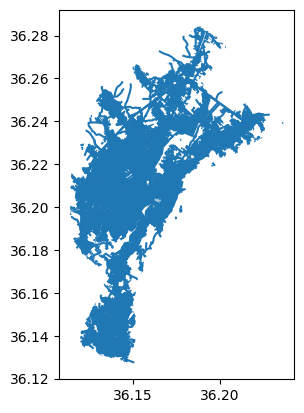

In [10]:
#representation of the data Antakya
data_antakya.plot()
data_antakya.head()

    4. Bahce:

Bahce is a small town located in the Osmaniye Province of Southern Turkey. Known for its rich agricultural practices, Bahce is surrounded by expansive fields and farmlands. The region is part of the Çukurova, a large and historically significant agricultural region in Turkey.

Info: https://en.wikipedia.org/wiki/Bah%C3%A7e,_Osmaniye

In [11]:

#path for buildings dataset
path_bahce_b = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_builtUpP_r1_v1.shp'

#path for facilities dataset
path_bahce_f = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_facilitiesL_r1_v1.shp'

#path for ancillary dataset
path_bahce_anc1 = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'

#area of interest
path_bahce_area = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#path for transportation dataset
path_bahce_transportation = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_transportationL_r1_v1.shp'

#path for counter elevatio  dataset
path_bahce_phisio = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_physiographyL_r1_v1.shp'

#path for water resources
path_bahce_hidro = '../data/vectors/BAHCE/M1_V1/EMSR648_AOI15_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI15_GRA_MONIT01_hydrographyL_r1_v1.shp'

data_bahce = (pd.concat([gpd.read_file(path_bahce_b),gpd.read_file(path_bahce_f),gpd.read_file(path_bahce_transportation)])
.sjoin(gpd.read_file(path_bahce_area), how='inner', op='within'))



/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
#Adding additional information od Bahce data
#adding population of last year and income in USD
data_bahce['population'], data_bahce['income'] =  22904, 6256
#total and second hand sales in the municipality in the last five years
data_bahce['total_sales'], data_bahce['second_sales'] =  1588, 664

# percentage of accecing clean city water in the province
data_bahce['water_access']= 0.95
#electric consumption of per capita
data_bahce['elec_cons']= 7413

#number of buildings permited
data_bahce['building_perm']= 583
#m2 of the land permited for construction
data_bahce['land_permited'] =  782505
#labour force participation and unemployment rate in the province
data_bahce['labour_fource'] = 48.1
data_bahce['unemployment'] = 17.1
#agricultural area in decares
data_bahce['agricultural'] = 1233061
#expected lifetinme
data_bahce['life_time'] = 78
#number of hospitals and beds in the province per 100000 people
data_bahce['hb_per100000']= 246
#fertility rate in the province
data_bahce['fertility']= 1.92
#average household size
data_bahce['hh_size']= 3.46

obj_type     name  \
0  12-Non-residential Buildings   BahÃ§e   
1  12-Non-residential Buildings  Unknown   
2  12-Non-residential Buildings  Unknown   
3  12-Non-residential Buildings  Unknown   
4  12-Non-residential Buildings  Unknown   

                                                info         damage_gra  \
0  1241-Communication buildings, stations, termin...  No visible damage   
1  1272-Buildings used as places of worship and f...  No visible damage   
2  1272-Buildings used as places of worship and f...  No visible damage   
3  1272-Buildings used as places of worship and f...  No visible damage   
4  1272-Buildings used as places of worship and f...  No visible damage   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building point        994           2   
1  Photo-interpretation  Building point        994           2   
2  Photo-interpretation  Building point        994           2   
3  Photo-interpretation  Building point        994           2   
4  Photo-interpretation  Building point        994           2   

         cd_value                   geometry  ...  elec_cons building_perm  \
0  Not Applicable  POINT (36.55905 37.18686)  ...       7413           583   
1  Not Applicable  POINT (36.57082 37.19470)  ...       7413           583   
2  Not Applicable  POINT (36.57653 37.19668)  ...       7413           583   
3  Not Applicable  POINT (36.56481 37.19341)  ...       7413           583   
4  Not Applicable  POINT (36.57324 37.20474)  ...       7413           583   

  land_permited labour_fource unemployment agricultural  life_time  \
0        782505          48.1         17.1      1233061         78   
1        782505          48.1         17.1      1233061         78   
2        782505          48.1         17.1      1233061         78   
3        782505          48.1         17.1      1233061         78   
4        782505          48.1         17.1      1233061         78   

   hb_per100000  fertility  hh_size  
0           246       1.92     3.46  
1           246       1.92     3.46  
2           246       1.92     3.46  
3           246       1.92     3.46  
4           246       1.92     3.46  

[5 rows x 31 columns]

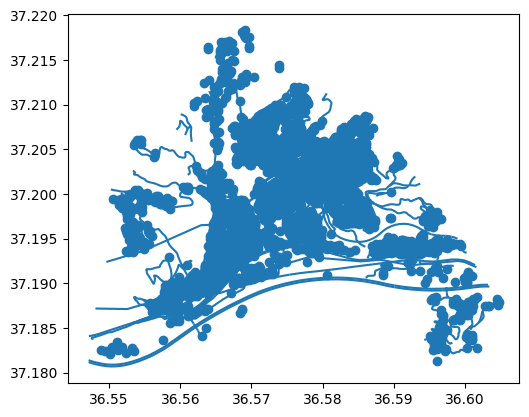

In [13]:
#basic representations of data
data_bahce.plot()
data_bahce.head()

    5. Diyarbakir:

Diyarbakir is one of the largest cities in southeastern Turkey and is rich in historical and cultural significance. Known for its impressive, black basalt city walls - one of the most extensive fortification systems in the world - the city has a history dating back thousands of years with influences from many empires, including the Romans, Byzantines, and Ottomans.

In [14]:
#Diyarbakir data

#buildings
path_diyarbakir = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_builtUpA_r1_v1.shp'
#ancillary info
path_diyarbakir_anc = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'

#area of interest
path_diyarbakir_area = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#diyarbakir has several transportation datasets for the same area
path_diyarbakir_transportation1 = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_transportationL_r1_v1.shp'
path_diyarbakir_transportation2 = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_transportationA_r1_v1.shp'

path_diyarbakir_transportation3 = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_transportationP_r1_v1.shp'

#water resources

path_diyarbakir_hidro = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_hydrographyA_r1_v1.shp'


#counter elevations
path_diyarbakir_phisio = '../data/vectors/DIYARBAKIR/M1_V1/EMSR648_AOI03_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI03_GRA_MONIT01_physiographyL_r1_v1.shp'

#merging buildings and transportation with area of interest
data_diyarbakir = (pd.concat([gpd.read_file(path_diyarbakir),gpd.read_file(path_diyarbakir_transportation1),gpd.read_file(path_diyarbakir_transportation2),gpd.read_file(path_diyarbakir_transportation3)])
.sjoin(gpd.read_file(path_diyarbakir_area), how='inner', op='within'))


dt= gpd.read_file(path_diyarbakir)

dt


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


obj_type     name                info        damage_gra  \
0   11-Residential Buildings  Unknown  997-Not Applicable           Damaged   
1   11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   
2   11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   
3   11-Residential Buildings  Unknown  997-Not Applicable           Damaged   
4   11-Residential Buildings  Unknown  997-Not Applicable           Damaged   
..                       ...      ...                 ...               ...   
92  11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   
93  11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   
94  11-Residential Buildings  Unknown  997-Not Applicable         Destroyed   
95  11-Residential Buildings  Unknown  997-Not Applicable           Damaged   
96  11-Residential Buildings  Unknown  997-Not Applicable           Damaged   

              det_method        notation  or_src_id  dmg_src_id  \
0   Photo-interpretation  Building block        994           3   
1   Photo-interpretation  Building block        994           3   
2   Photo-interpretation  Building block        994           3   
3   Photo-interpretation  Building block        994           3   
4   Photo-interpretation  Building block        994           3   
..                   ...             ...        ...         ...   
92  Photo-interpretation  Building block        994           3   
93  Photo-interpretation  Building block        994           4   
94  Photo-interpretation  Building block          4           4   
95  Photo-interpretation  Building block          4           4   
96  Photo-interpretation  Building block          4           4   

          cd_value            real  \
0   Not Applicable  Not Applicable   
1   Not Applicable  Not Applicable   
2   Not Applicable  Not Applicable   
3   Not Applicable  Not Applicable   
4   Not Applicable  Not Applicable   
..             ...             ...   
92  Not Applicable  Not Applicable   
93  Not Applicable  Not Applicable   
94  Not Applicable  Not Applicable   
95  Not Applicable  Not Applicable   
96  Not Applicable  Not Applicable   

                                             geometry  
0   POLYGON ((40.18035 37.90188, 40.17963 37.90169...  
1   POLYGON ((40.22586 37.88913, 40.22606 37.88790...  
2   POLYGON ((40.22741 37.90586, 40.22719 37.90537...  
3   POLYGON ((40.22356 37.90630, 40.22349 37.90629...  
4   POLYGON ((40.22143 37.90500, 40.22142 37.90495...  
..                                                ...  
92  POLYGON ((40.22847 37.90942, 40.22832 37.90924...  
93  POLYGON ((40.23120 37.91553, 40.23023 37.91521...  
94  POLYGON ((40.22089 37.91718, 40.22048 37.91753...  
95  POLYGON ((40.23406 37.90828, 40.23316 37.90824...  
96  POLYGON ((40.22089 37.91718, 40.22128 37.91736...  

[97 rows x 11 columns]

In [15]:
#adding population of last year and income in USD
data_diyarbakir['population'], data_diyarbakir['income'] =  1804880, 3893
#total and second hand sales in the municipality in the last five years
data_diyarbakir['total_sales'], data_diyarbakir['second_sales'] =  145244, 83985

# percentage of accecing clean city water in the province
data_diyarbakir['water_access']= 0.95
#electric consumption of per capita
data_diyarbakir['elec_cons']= 1631
#number of buildings permited
data_diyarbakir['building_perm']=  1336
#m2 of the land permited for construction
data_diyarbakir['land_permited'] =  1996910
#labour force participation and unemployment rate in the province
data_diyarbakir['labour_fource'] = 40.6
data_diyarbakir['unemployment'] = 15.00
#agricultural area in decares
data_diyarbakir['agricultural'] =  5735761
#expected lifetinme
data_diyarbakir['life_time'] = 78.9  
#number of hospitals and beds in the province per 100000 people
data_diyarbakir['hb_per100000']=  269
#fertility rate in the province
data_diyarbakir['fertility']=  2.54
#average household size
data_diyarbakir['hh_size']=  4.43

obj_type                          name  \
0           11-Residential Buildings                       Unknown   
1           11-Residential Buildings                       Unknown   
2           11-Residential Buildings                       Unknown   
3           11-Residential Buildings                       Unknown   
4           11-Residential Buildings                       Unknown   
..                               ...                           ...   
797  211-Highways, Streets and Roads                       Unknown   
798  211-Highways, Streets and Roads  DiyarbakÄ±r-ÅanlÄ±urfa yolu   
799  211-Highways, Streets and Roads  DiyarbakÄ±r-ÅanlÄ±urfa yolu   
0                       213-Airfield                       Unknown   
0                       213-Airfield       DiyarbakÄ±r HavalimanÄ±   

                      info         damage_gra            det_method  \
0       997-Not Applicable            Damaged  Photo-interpretation   
1       997-Not Applicable   Possibly damaged  Photo-interpretation   
2       997-Not Applicable   Possibly damaged  Photo-interpretation   
3       997-Not Applicable            Damaged  Photo-interpretation   
4       997-Not Applicable            Damaged  Photo-interpretation   
..                     ...                ...                   ...   
797          2111-Highways  No visible damage  Photo-interpretation   
798          2111-Highways  No visible damage  Photo-interpretation   
799          2111-Highways  No visible damage  Photo-interpretation   
0    2130-Airfield runways  No visible damage  Photo-interpretation   
0    2130-Airfield runways  No visible damage  Photo-interpretation   

           notation  or_src_id  dmg_src_id        cd_value            real  \
0    Building block        994           3  Not Applicable  Not Applicable   
1    Building block        994           3  Not Applicable  Not Applicable   
2    Building block        994           3  Not Applicable  Not Applicable   
3    Building block        994           3  Not Applicable  Not Applicable   
4    Building block        994           3  Not Applicable  Not Applicable   
..              ...        ...         ...             ...             ...   
797  Not Applicable        994           2  Not Applicable             NaN   
798  Not Applicable        994           2  Not Applicable             NaN   
799  Not Applicable        994           2  Not Applicable             NaN   
0    Not Applicable        994           3  Not Applicable             NaN   
0    Not Applicable          1           3  Not Applicable             NaN   

     ... elec_cons  building_perm land_permited labour_fource unemployment  \
0    ...      1631           1336       1996910          40.6         15.0   
1    ...      1631           1336       1996910          40.6         15.0   
2    ...      1631           1336       1996910          40.6         15.0   
3    ...      1631           1336       1996910          40.6         15.0   
4    ...      1631           1336       1996910          40.6         15.0   
..   ...       ...            ...           ...           ...          ...   
797  ...      1631           1336       1996910          40.6         15.0   
798  ...      1631           1336       1996910          40.6         15.0   
799  ...      1631           1336       1996910          40.6         15.0   
0    ...      1631           1336       1996910          40.6         15.0   
0    ...      1631           1336       1996910          40.6         15.0   

    agricultural life_time  hb_per100000  fertility  hh_size  
0        5735761      78.9           269       2.54     4.43  
1        5735761      78.9           269       2.54     4.43  
2        5735761      78.9           269       2.54     4.43  
3        5735761      78.9           269       2.54     4.43  
4        5735761      78.9           269       2.54     4.43  
..           ...       ...           ...        ...      ...  
797      5735761   

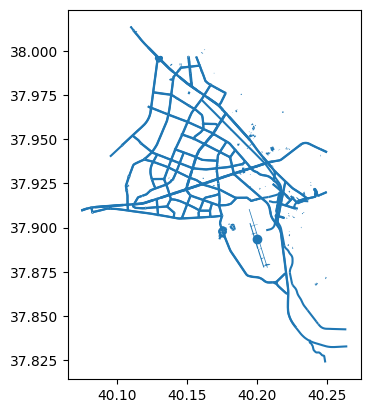

In [16]:
#Representation of data

data_diyarbakir.plot()
data_diyarbakir

    6.Duzici : 

Düzici is a town and district of Osmaniye Province in the Mediterranean region of Turkey. As a relatively small district, it carries its own unique local charm. The area is primarily agricultural, with farming being a significant part of the local economy. Given its location in the Mediterranean region, Düzici enjoys a mild climate with hot, dry summers and warm, wet winters, which is conducive to growing a variety of crops. Despite its size, Düzici and its surrounding regions hold cultural and historical significance, being part of a country with a rich history dating back thousands of years.

In [17]:
#Duzici data

#buildings and facilities

path_duzici_b = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_builtUpP_r1_v1.shp'
path_duzici_f = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_facilitiesA_r1_v1.shp'

#area of interest
path_duzici_area = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#ancillary data
path_duzici_anc1 = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'
path_duzici_anc2 = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'

#water bodies
path_duzici_hidro = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_hydrographyL_r1_v1.shp'

# counter elevation lines
path_duzici_phisio = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_physiographyL_r1_v1.shp'

#transportation
path_duzici_transportation = '../data/vectors/DUZICI/M1_V1/EMSR648_AOI14_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI14_GRA_MONIT01_transportationL_r1_v1.shp'

data_duzici = (pd.concat([gpd.read_file(path_duzici_b),gpd.read_file(path_duzici_f),gpd.read_file(path_duzici_transportation)])
               .sjoin(gpd.read_file(path_duzici_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
#adding population of last year and income in USD
data_duzici['population'], data_duzici['income'] = 85448, 6256
#total and second hand sales in the municipality in the last five years
data_duzici['total_sales'], data_duzici['second_sales'] =  6203, 2289

 # percentage of accecing clean city water in the province
data_duzici['water_access']= 0.95
#electric consumption of per capita
data_duzici['elec_cons']= 7413

#number of buildings permited
data_duzici['building_perm']= 583
#m2 of the land permited for construction
data_duzici['land_permited'] =  782505
#labour force participation and unemployment rate in the province
data_duzici['labour_fource'] = 48.1
data_duzici['unemployment'] = 17.1
#agricultural area in decares
data_duzici['agricultural'] = 1233061
#expected lifetinme
data_duzici['life_time'] = 78
#number of hospitals and beds in the province per 100000 people
data_duzici['hb_per100000']= 246
#fertility rate in the province
data_duzici['fertility']= 1.92
#average household size
data_duzici['hh_size']= 3.46


obj_type                                    name  \
0      11-Residential Buildings                                 Unknown   
1  12-Non-residential Buildings  DÃ¼ziÃ§i Ä°lÃ§e Emniyet MÃ¼dÃ¼rlÃ¼ÄÃ¼   
2  12-Non-residential Buildings                                    Stad   
3  12-Non-residential Buildings                                 Unknown   
4  12-Non-residential Buildings                                 Unknown   

                                                info         damage_gra  \
0                                 997-Not Applicable  No visible damage   
1                                1222-Police station  No visible damage   
2                1261-Public entertainment buildings  No visible damage   
3  1272-Buildings used as places of worship and f...  No visible damage   
4  1272-Buildings used as places of worship and f...  No visible damage   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building point        997           3   
1  Photo-interpretation  Building point        994           3   
2  Photo-interpretation  Building point        994           3   
3  Photo-interpretation  Building point        994           3   
4  Photo-interpretation  Building point        994           3   

         cd_value                   geometry  ...  elec_cons building_perm  \
0  Not Applicable  POINT (36.46779 37.24987)  ...       7413           583   
1  Not Applicable  POINT (36.46377 37.24967)  ...       7413           583   
2  Not Applicable  POINT (36.46134 37.25710)  ...       7413           583   
3  Not Applicable  POINT (36.46643 37.25004)  ...       7413           583   
4  Not Applicable  POINT (36.46539 37.24486)  ...       7413           583   

  land_permited labour_fource unemployment agricultural  life_time  \
0        782505          48.1         17.1      1233061         78   
1        782505          48.1         17.1      1233061         78   
2        782505          48.1         17.1      1233061         78   
3        782505          48.1         17.1      1233061         78   
4        782505          48.1         17.1      1233061         78   

   hb_per100000  fertility  hh_size  
0           246       1.92     3.46  
1           246       1.92     3.46  
2           246       1.92     3.46  
3           246       1.92     3.46  
4           246       1.92     3.46  

[5 rows x 31 columns]

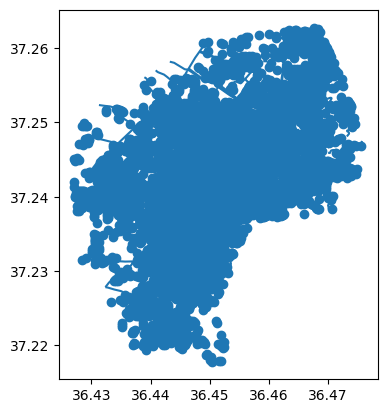

In [19]:
# representativplot and head of the dataset
data_duzici.plot()
data_duzici.head()

    7. Elbistan:

Elbistan is a district in Kahramanmaraş Province in southern Turkey, located in the eastern part of the Mediterranean region. It's the most populous district of the province and known primarily for its extensive coal reserves. The Elbistan area has the largest lignite (brown coal) deposit in Turkey, and there are major power plants in the district to utilize this resource.


In [20]:
#buildings and facilities
path_elbistan_b = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_builtUpP_r1_v1.shp'
path_elbistan_f = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_facilitiesA_r1_v1.shp'


#ancillary and area of interest

path_elbistan_anc = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
path_elbistan_area = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_areaOfInterestA_r1_v1.shp'


#watersources

path_elbistan_hidro = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_hydrographyL_r1_v1.shp'

#physiography
path_elbistan_phisio = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_physiographyL_r1_v1.shp'

path_elbistan_transportation = '../data/vectors/ELBISTAN/M1_V1/EMSR648_AOI20_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI20_GRA_MONIT01_transportationL_r1_v1.shp'

data_elbistan = (pd.concat([gpd.read_file(path_elbistan_b),gpd.read_file(path_elbistan_f),gpd.read_file(path_elbistan_transportation)])
                 .sjoin(gpd.read_file(path_elbistan_area), how='inner', op='within'))

/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
#adding population of last year and income in USD
data_elbistan['population'], data_elbistan['income'] =  77180,  5997
#total and second hand sales in the municipality in the last five years
data_elbistan['total_sales'], data_elbistan['second_sales'] =  18139, 10133

# percentage of accecing clean city water in the province
data_elbistan['water_access']= 0.95
#electric consumption of per capita
data_elbistan['elec_cons']= 4343
#number of buildings permited
data_elbistan['building_perm']= 1528
#m2 of the land permited for construction in province
data_elbistan['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_elbistan['labour_fource'] = 48.1
data_elbistan['unemployment'] = 17.1

#agricultural area in decares
data_elbistan['agricultural'] = 3535085
#expected lifetinme
data_elbistan['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_elbistan['hb_per100000']= 256
#fertility rate in the province
data_elbistan['fertility']= 1.99
#average household size
data_elbistan['hh_size']= 3.68

obj_type     name                info        damage_gra  \
0  11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   
1  11-Residential Buildings  Unknown  997-Not Applicable         Destroyed   
2  11-Residential Buildings  Unknown  997-Not Applicable         Destroyed   
3  11-Residential Buildings  Unknown  997-Not Applicable         Destroyed   
4  11-Residential Buildings  Unknown  997-Not Applicable         Destroyed   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building point          3           3   
1  Photo-interpretation  Building point          3           3   
2  Photo-interpretation  Building point          3           3   
3  Photo-interpretation  Building point          3           3   
4  Photo-interpretation  Building point          3           3   

         cd_value                   geometry  ...  elec_cons building_perm  \
0  Not Applicable  POINT (37.21543 38.19121)  ...       4343          1528   
1  Not Applicable  POINT (37.21705 38.19295)  ...       4343          1528   
2  Not Applicable  POINT (37.21855 38.19418)  ...       4343          1528   
3  Not Applicable  POINT (37.21797 38.19479)  ...       4343          1528   
4  Not Applicable  POINT (37.20122 38.18842)  ...       4343          1528   

  land_permited labour_fource unemployment agricultural  life_time  \
0       2222311          48.1         17.1      3535085       79.2   
1       2222311          48.1         17.1      3535085       79.2   
2       2222311          48.1         17.1      3535085       79.2   
3       2222311          48.1         17.1      3535085       79.2   
4       2222311          48.1         17.1      3535085       79.2   

   hb_per100000  fertility  hh_size  
0           256       1.99     3.68  
1           256       1.99     3.68  
2           256       1.99     3.68  
3           256       1.99     3.68  
4           256       1.99     3.68  

[5 rows x 31 columns]

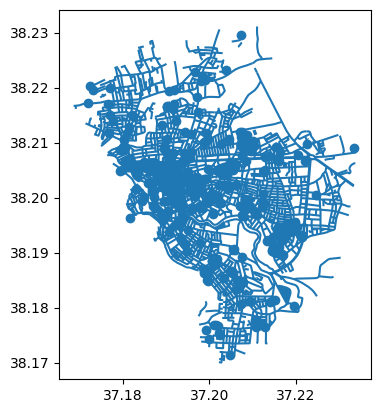

In [22]:
# basis representations:

data_elbistan.plot()
data_elbistan.head()

    8.Erdemoglu:

Adiyaman is a city in southeastern Turkey known for its historical and archaeological sites.In dataset, consist of buildings and transportation.

In [23]:
#data Erdemoglu

#Building dataset
path_erdemoglu = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_builtUpP_r1_v1.shp'
#ancilarry dataset
path_erdemoglu_anc = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
#area of interest
path_erdemoglu_area = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
# roads dataset
path_transportation = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_transportationL_r1_v1.shp'
# water resources
path_erdemoglu_hidro = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_hydrographyL_r1_v1.shp'

# counter elevation
path_erdemoglu_phisio = '../data/vectors/ERDEMOGLU/M1_V1/EMSR648_AOI12_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI12_GRA_MONIT01_physiographyL_r1_v1.shp'

#merging building and transportation and adding area of interest info to the dataset
data_erdemoglu = (pd.concat([gpd.read_file(path_erdemoglu),gpd.read_file(path_transportation)])
                  .sjoin(gpd.read_file(path_erdemoglu_area), how='inner', op='within'))




/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
#adding population of last year and income in USD
data_erdemoglu['population'], data_erdemoglu['income'] =  77180, 4092
#total and second hand sales in the municipality in the last five years
data_erdemoglu['total_sales'], data_erdemoglu['second_sales'] =  9675, 4098

# percentage of accecing clean city water in the province
data_erdemoglu['water_access']= 0.98
#electric consumption of per capita
data_erdemoglu['elec_cons']= 2060
#number of buildings permited
data_erdemoglu['building_perm']= 810
#m2 of the land permited for construction
data_erdemoglu['land_permited'] = 695718
#labour force participation and unemployment rate in the province
data_erdemoglu['labour_fource'] = 50
data_erdemoglu['unemployment'] = 10.1

#agricultural area in decares
data_erdemoglu['agricultural'] = 2336012
#expected lifetinme

data_erdemoglu['life_time'] = 79.7
#number of hospitals and beds in the province per 100000 people
data_erdemoglu['hb_per100000']= 222
#fertility rate in the province
data_erdemoglu['fertility']= 2.36
#average household size
data_erdemoglu['hh_size']= 4

obj_type     name                info        damage_gra  \
0  11-Residential Buildings  Unknown  997-Not Applicable           Damaged   
1  11-Residential Buildings  Unknown  997-Not Applicable           Damaged   
2  11-Residential Buildings  Unknown  997-Not Applicable         Destroyed   
3  11-Residential Buildings  Unknown  997-Not Applicable           Damaged   
4  11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building point          1           3   
1  Photo-interpretation  Building point          1           3   
2  Photo-interpretation  Building point          1           3   
3  Photo-interpretation  Building point          1           3   
4  Photo-interpretation  Building point          1           3   

         cd_value                   geometry  ...  elec_cons building_perm  \
0  Not Applicable  POINT (37.86464 37.68615)  ...       2060           810   
1  Not Applicable  POINT (37.86259 37.68635)  ...       2060           810   
2  Not Applicable  POINT (37.86284 37.68618)  ...       2060           810   
3  Not Applicable  POINT (37.86414 37.68622)  ...       2060           810   
4  Not Applicable  POINT (37.86067 37.68593)  ...       2060           810   

  land_permited labour_fource unemployment agricultural  life_time  \
0        695718            50         10.1      2336012       79.7   
1        695718            50         10.1      2336012       79.7   
2        695718            50         10.1      2336012       79.7   
3        695718            50         10.1      2336012       79.7   
4        695718            50         10.1      2336012       79.7   

   hb_per100000  fertility  hh_size  
0           222       2.36        4  
1           222       2.36        4  
2           222       2.36        4  
3           222       2.36        4  
4           222       2.36        4  

[5 rows x 31 columns]

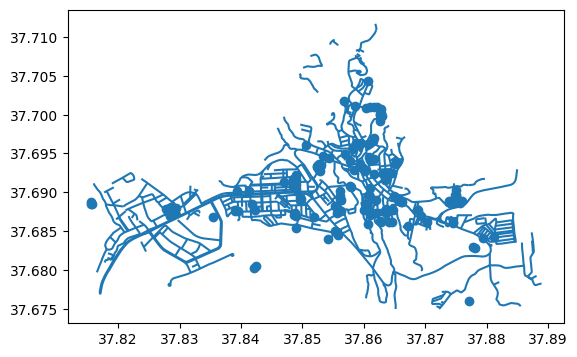

In [25]:
# basic representations of the data

data_erdemoglu.plot()
data_erdemoglu.head()

    9.Gaziantep: 

Gaziantep, often simply referred to as Antep, is a city located in southeastern Turkey. It's one of the oldest continuously inhabited cities in the world, with a history dating back to the Hittite era. Gaziantep is renowned for its unique culinary traditions, especially its pistachio-based baklava, and its large, diverse collection of Roman mosaics housed in the Zeugma Mosaic Museum. Its vibrant bazaars, rich history, and cultural heritage make Gaziantep a fascinating destination for visitors.

Info: https://en.wikipedia.org/wiki/Gaziantep

Dataset includes building, facilities and transportation info.

In [26]:
# data for Gaziantep
#buildings
path_gaziantep_b = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_builtUpP_r1_v1.shp'
#facilities
path_gaziantep_f = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_facilitiesL_r1_v1.shp'
#area of interest in polygon
path_gaziantep_area = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
# anciliary crisis info
path_gaziantep_anc = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
# Water resources
path_gaziantep_hidro = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_hydrographyL_r1_v1.shp'
# Transportation
path_gaziantep_transportation = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_transportationL_r1_v1.shp'
#Elevation countours
path_gaziantep_phisio = '../data/vectors/GAZIANTEP/M1_V1/EMSR648_AOI01_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI01_GRA_MONIT01_physiographyL_r1_v1.shp'

#merging buildings, facilities and transportation and spatial joining with area of interest
data_gaziantep = (pd.concat([gpd.read_file(path_gaziantep_b),gpd.read_file(path_gaziantep_f),gpd.read_file(path_gaziantep_transportation)])
                  .sjoin(gpd.read_file(path_gaziantep_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
#adding population of last year and income in USD
data_gaziantep['population'], data_gaziantep['income'] =  2154051, 7819
#total and second hand sales in the municipality in the last five years
data_gaziantep['total_sales'], data_gaziantep['second_sales'] =  248121, 141434

# percentage of accecing clean city water in the province
data_gaziantep['water_access']= 1
#electric consumption of per capita
data_gaziantep['elec_cons']=  4076
#number of buildings permited
data_gaziantep['building_perm']=  2959
#m2 of the land permited for construction
data_gaziantep['land_permited'] =  3019546
#labour force participation and unemployment rate in the province
data_gaziantep['labour_fource'] =  50
data_gaziantep['unemployment'] =  10.1
#agricultural area in decares
data_gaziantep['agricultural'] =  3466185
#expected lifetinme
data_gaziantep['life_time'] =  76.9
#number of hospitals and beds in the province per 100000 people
data_gaziantep['hb_per100000']=  306
#fertility rate in the province
data_gaziantep['fertility']=  2.47
#average household size
data_gaziantep['hh_size']=  3.97

obj_type     name  \
0      11-Residential Buildings  Unknown   
1      11-Residential Buildings  Unknown   
2  12-Non-residential Buildings  Unknown   
3              995-Unclassified  Unknown   
4              995-Unclassified  Unknown   

                                                info         damage_gra  \
0                                 997-Not Applicable  No visible damage   
1                                 997-Not Applicable  No visible damage   
2  1272-Buildings used as places of worship and f...  No visible damage   
3                                 997-Not Applicable  No visible damage   
4                                 997-Not Applicable  No visible damage   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building point        994           2   
1  Photo-interpretation  Building point        994           2   
2  Photo-interpretation  Building point        994           2   
3  Photo-interpretation  Building point        994           2   
4  Photo-interpretation  Building point        994           2   

         cd_value                   geometry  ...  elec_cons building_perm  \
0  Not Applicable  POINT (37.31766 37.08173)  ...       4076          2959   
1  Not Applicable  POINT (37.31766 37.08122)  ...       4076          2959   
2  Not Applicable  POINT (37.31761 37.08369)  ...       4076          2959   
3  Not Applicable  POINT (37.32050 37.10427)  ...       4076          2959   
4  Not Applicable  POINT (37.32080 37.10423)  ...       4076          2959   

  land_permited labour_fource unemployment agricultural  life_time  \
0       3019546            50         10.1      3466185       76.9   
1       3019546            50         10.1      3466185       76.9   
2       3019546            50         10.1      3466185       76.9   
3       3019546            50         10.1      3466185       76.9   
4       3019546            50         10.1      3466185       76.9   

   hb_per100000  fertility  hh_size  
0           306       2.47     3.97  
1           306       2.47     3.97  
2           306       2.47     3.97  
3           306       2.47     3.97  
4           306       2.47     3.97  

[5 rows x 31 columns]

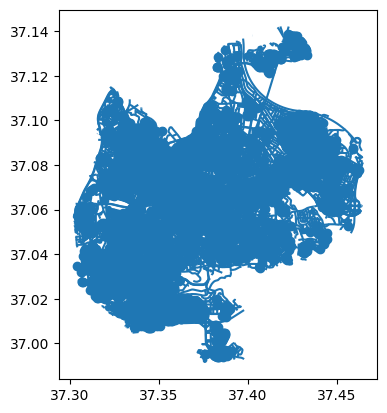

In [28]:
#basic representations
data_gaziantep.plot()
data_gaziantep.head()

    10.Golbasi:

Gölbaşı is a town and district in the Adıyaman Province of Turkey. It's located in the southeastern part of the country and is known for its natural beauty and cultural heritage. One of the main attractions of Gölbaşı is Lake Gölbaşı (Gölbaşı Gölü), a substantial body of water known for its diverse bird population and scenic beauty. The district also houses historical sites and landmarks, offering a peek into the region's rich history and traditions.

Info: https://en.wikipedia.org/wiki/G%C3%B6lba%C5%9F%C4%B1,_Ad%C4%B1yaman

Facilities, Buildings are saved in different locations

In [29]:
# paths for building and facility data
path_golbasi_b = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_builtUpP_r1_v1.shp'
path_golbasi_f = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_facilitiesA_r1_v1.shp'
path_golbasi2_b = '../data/vectors/GOLBASI/M2_V2/EMSR648_AOI13_GRA_MONIT02_r1_RTP01_v2_vector/EMSR648_AOI13_GRA_MONIT02_builtUpP_r1_v2.shp'
path_golbasi2_f = '../data/vectors/GOLBASI/M2_V2/EMSR648_AOI13_GRA_MONIT02_r1_RTP01_v2_vector/EMSR648_AOI13_GRA_MONIT02_facilitiesL_r1_v2.shp'
# ancillary data
path_golbasi_anc ='../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
# area of interest
path_golbasi_area = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
# countour lines
path_golbasi_phisio = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_physiographyL_r1_v1.shp'
#water resources
path_golbasi_hidro = '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_hydrographyL_r1_v1.shp'
#transportation daata
path_golbasi_transportation= '../data/vectors/GOLBASI/M1_V1/EMSR648_AOI13_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI13_GRA_MONIT01_transportationL_r1_v1.shp'

#merging building and facility data and adding area of interest
data_golbasi = (pd.concat([gpd.read_file(path_golbasi_b), gpd.read_file(path_golbasi_f),gpd.read_file(path_golbasi2_b), gpd.read_file(path_golbasi2_f), gpd.read_file(path_golbasi_transportation)])
                          .sjoin(gpd.read_file(path_golbasi_area), how='inner', op='within'))



/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
#adding population of last year and income in USD
data_golbasi['population'], data_golbasi['income'] =  50326, 4092
#total and second hand sales in the municipality in the last five years
data_golbasi['total_sales'], data_golbasi['second_sales'] =  6455, 2236

# percentage of accecing clean city water in the province
data_golbasi['water_access']= 0.98
#electric consumption of per capita
data_golbasi['elec_cons']= 2060
#number of buildings permited
data_golbasi['building_perm']= 810
#m2 of the land permited for construction
data_golbasi['land_permited'] = 695718
#labour force participation and unemployment rate in the province
data_golbasi['labour_fource'] = 50
data_golbasi['unemployment'] = 10.1

#agricultural area in decares
data_golbasi['agricultural'] = 2336012
#expected lifetinme

data_golbasi['life_time'] = 79.7
#number of hospitals and beds in the province per 100000 people
data_golbasi['hb_per100000']= 222
#fertility rate in the province
data_golbasi['fertility']= 2.36
#average household size
data_golbasi['hh_size']= 4


obj_type     name                info  \
0  12-Non-residential Buildings  Unknown  997-Not Applicable   
1  12-Non-residential Buildings  Unknown  997-Not Applicable   
2  12-Non-residential Buildings  Unknown  997-Not Applicable   
3  12-Non-residential Buildings  Unknown  997-Not Applicable   
4  12-Non-residential Buildings  Unknown  997-Not Applicable   

         damage_gra            det_method        notation  or_src_id  \
0  Possibly damaged  Photo-interpretation  Building point          3   
1  Possibly damaged  Photo-interpretation  Building point          3   
2  Possibly damaged  Photo-interpretation  Building point          3   
3  Possibly damaged  Photo-interpretation  Building point          3   
4         Destroyed  Photo-interpretation  Building point          3   

   dmg_src_id        cd_value                   geometry  ...  elec_cons  \
0           3  Not Applicable  POINT (37.63009 37.77716)  ...       2060   
1           3  Not Applicable  POINT (37.63643 37.78074)  ...       2060   
2           3  Not Applicable  POINT (37.64121 37.78130)  ...       2060   
3           3  Not Applicable  POINT (37.63923 37.78451)  ...       2060   
4           3  Not Applicable  POINT (37.64318 37.78836)  ...       2060   

  building_perm land_permited labour_fource unemployment agricultural  \
0           810        695718            50         10.1      2336012   
1           810        695718            50         10.1      2336012   
2           810        695718            50         10.1      2336012   
3           810        695718            50         10.1      2336012   
4           810        695718            50         10.1      2336012   

   life_time  hb_per100000  fertility  hh_size  
0       79.7           222       2.36        4  
1       79.7           222       2.36        4  
2       79.7           222       2.36        4  
3       79.7           222       2.36        4  
4       79.7           222       2.36        4  

[5 rows x 31 columns]

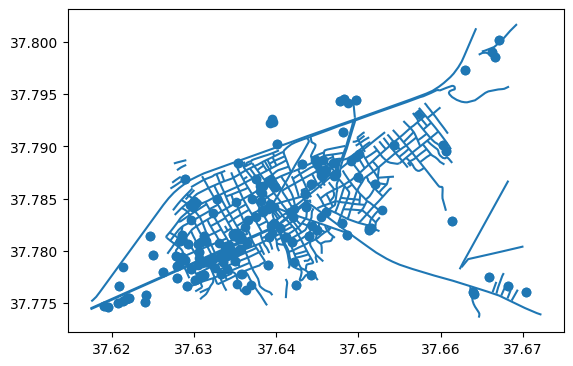

In [31]:
# Basic representations

data_golbasi.plot()
data_golbasi.head()

    11. Islahiye:

Islahiye is a town and district in the Gaziantep Province of southeastern Turkey. It is nestled between the Mediterranean and Southeastern Anatolia regions and is known for its rich history, agriculture, and diverse cultural heritage. Islahiye is surrounded by mountains and features fertile plains, making it a significant center for agriculture, particularly for growing cereals, legumes, and fruits. The area also has several ancient sites and ruins, reflecting its history that dates back to the Hittite period.

Info: https://en.wikipedia.org/wiki/%C4%B0slahiye_District 

Data has building and transportation information in different folders.

In [32]:
#data of Islahiye

#buildings

path_islahiye = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_builtUpA_r1_v1.shp'
path_islahiye2 = '../data/vectors/ISLAHIYE/M2_V1/EMSR648_AOI10_GRA_MONIT02_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT02_builtUpA_r1_v1.shp'
#area of interest
path_islahiye_area = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#ancillary crisis info 
path_islahiye_anc1 = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'

path_islahiye_anc2 = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
#water sources
path_islahiye_hidro= '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_hydrographyL_r1_v1.shp'
# countour elevation
path_islahiye_physio = '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_physiographyL_r1_v1.shp'
# roads
path_islahiye_transportation1= '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_transportationA_r1_v1.shp'

path_islahiye_transportation2= '../data/vectors/ISLAHIYE/M1_V1/EMSR648_AOI10_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI10_GRA_MONIT01_transportationL_r1_v1.shp'

#merging buildings and area of interest
data_islahiye = (pd.concat([gpd.read_file(path_islahiye), gpd.read_file(path_islahiye2),gpd.read_file(path_islahiye2), gpd.read_file(path_islahiye_transportation1), gpd.read_file(path_islahiye_transportation2)])
                          .sjoin(gpd.read_file(path_islahiye_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
# Data from Turkish Statistical Institute (TUIK) 

data_islahiye['population'], data_islahiye['income'] =  67650, 7819
#total and second hand sales in the municipality in the last five years
data_islahiye['total_sales'], data_islahiye['second_sales'] =  4498, 1892

# percentage of accecing clean city water in the province
data_islahiye['water_access']= 1
#electric consumption of per capita
data_islahiye['elec_cons']=  4076
#number of buildings permited
data_islahiye['building_perm']=  2959
#m2 of the land permited for construction
data_islahiye['land_permited'] =  3019546
#labour force participation and unemployment rate in the province
data_islahiye['labour_fource'] =  50
data_islahiye['unemployment'] =  10.1
#agricultural area in decares
data_islahiye['agricultural'] =  3466185
#expected lifetinme
data_islahiye['life_time'] =  76.9
#number of hospitals and beds in the province per 100000 people
data_islahiye['hb_per100000']=  306
#fertility rate in the province
data_islahiye['fertility']=  2.47
#average household size
data_islahiye['hh_size']=  3.97


obj_type     name                                 info  \
0  12-Non-residential Buildings  Unknown  1271-Non-residential farm buildings   
1      11-Residential Buildings  Unknown                   997-Not Applicable   
2      11-Residential Buildings  Unknown                   997-Not Applicable   
3      11-Residential Buildings  Unknown                   997-Not Applicable   
4      11-Residential Buildings  Unknown                   997-Not Applicable   

          damage_gra            det_method        notation  or_src_id  \
0  No visible damage  Photo-interpretation  Building block        994   
1   Possibly damaged  Photo-interpretation  Building block        994   
2  No visible damage  Photo-interpretation  Building block        994   
3  No visible damage  Photo-interpretation  Building block        994   
4  No visible damage  Photo-interpretation  Building block        994   

   dmg_src_id        cd_value  real  ... elec_cons  building_perm  \
0           3  Not Applicable  None  ...      4076           2959   
1           3  Not Applicable  None  ...      4076           2959   
2           3  Not Applicable  None  ...      4076           2959   
3           3  Not Applicable  None  ...      4076           2959   
4           3  Not Applicable  None  ...      4076           2959   

  land_permited labour_fource unemployment agricultural life_time  \
0       3019546            50         10.1      3466185      76.9   
1       3019546            50         10.1      3466185      76.9   
2       3019546            50         10.1      3466185      76.9   
3       3019546            50         10.1      3466185      76.9   
4       3019546            50         10.1      3466185      76.9   

   hb_per100000  fertility  hh_size  
0           306       2.47     3.97  
1           306       2.47     3.97  
2           306       2.47     3.97  
3           306       2.47     3.97  
4           306       2.47     3.97  

[5 rows x 32 columns]

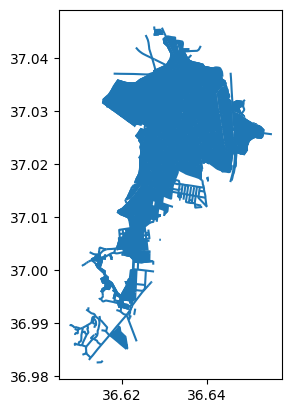

In [34]:
#bsic repreentation of data
data_islahiye.plot()
data_islahiye.head()

    12. Kahramanmaras:

Kahramanmaraş is a city in the Mediterranean Region of Turkey and the administrative center of Kahramanmaraş Province. Known historically as Marash, the city has a rich history that stretches back to the Hittite civilization. It is renowned for its production of high-quality textiles, handcrafted goods, and notably, its distinctive ice cream, also known as Maras ice cream, which is famously chewy and dense. In terms of geography, Kahramanmaraş is surrounded by mountains and has a typical Mediterranean climate with hot, dry summers and mild, wet winters. The city's cultural heritage, coupled with its vibrant local industries, makes it a significant center in the region. Please note that as of my last training data cut-off in September 2021, certain current details or developments may not be included.

Info: https://en.wikipedia.org/wiki/Kahramanmara%C5%9F

Data of Kahramanmaras has 2 different files for water resources. main dataset will include building, facility and transportation

In [35]:
# Data Kahramanmaras

#buildings

path_kahramanmaras_b= '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_builtUpP_r1_v1.shp'

#facilities
path_kahramanmaras_f = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_facilitiesA_r1_v1.shp'

#area of interest
path_kahramanmaras_area = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
#ancillary crisis info

path_kahramanmaras_anc = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'

#water resources
path_kahramanmaras_hidroA = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_hydrographyA_r1_v1.shp'

path_kahramanmaras_hidroL = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_hydrographyL_r1_v1.shp'

#transportation/roads
path_kahramanmaras_transportation = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_transportationL_r1_v1.shp'
# Counter elevation
path_kahramanmaras_phisio = '../data/vectors/KAHRAMANMARAS/M1_V1/EMSR648_AOI04_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI04_GRA_MONIT01_physiographyL_r1_v1.shp'

# merging building, facilities and transportation and adding area of interest
data_kahramanmaras = (pd.concat([gpd.read_file(path_kahramanmaras_b), gpd.read_file(path_kahramanmaras_f), gpd.read_file(path_kahramanmaras_transportation)])
                      .sjoin(gpd.read_file(path_kahramanmaras_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
#adding population of last year and income in USD
data_kahramanmaras['population'], data_kahramanmaras['income'] = 806936, 5997
#total and second hand sales in the municipality in the last five years
data_kahramanmaras['total_sales'], data_kahramanmaras['second_sales'] =  87599, 42683

# percentage of accecing clean city water in the province
data_kahramanmaras['water_access']= 0.95
#electric consumption of per capita
data_kahramanmaras['elec_cons']= 4343
#number of buildings permited
data_kahramanmaras['building_perm']= 1528
#m2 of the land permited for construction in province
data_kahramanmaras['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_kahramanmaras['labour_fource'] = 48.1
data_kahramanmaras['unemployment'] = 17.1

#agricultural area in decares
data_kahramanmaras['agricultural'] = 3535085
#expected lifetinme
data_kahramanmaras['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_kahramanmaras['hb_per100000']= 256
#fertility rate in the province
data_kahramanmaras['fertility']= 1.99
#average household size
data_kahramanmaras['hh_size']= 3.68


obj_type     name                info damage_gra  \
0  11-Residential Buildings  Unknown  997-Not Applicable  Destroyed   
1  11-Residential Buildings  Unknown  997-Not Applicable  Destroyed   
2  11-Residential Buildings  Unknown  997-Not Applicable  Destroyed   
3  11-Residential Buildings  Unknown  997-Not Applicable  Destroyed   
4  11-Residential Buildings  Unknown  997-Not Applicable  Destroyed   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building point          2           2   
1  Photo-interpretation  Building point          2           2   
2  Photo-interpretation  Building point          2           2   
3  Photo-interpretation  Building point          2           2   
4  Photo-interpretation  Building point          2           2   

         cd_value                   geometry  ...  elec_cons building_perm  \
0  Not Applicable  POINT (36.92621 37.57709)  ...       4343          1528   
1  Not Applicable  POINT (36.92612 37.57676)  ...       4343          1528   
2  Not Applicable  POINT (36.92607 37.57653)  ...       4343          1528   
3  Not Applicable  POINT (36.92600 37.57622)  ...       4343          1528   
4  Not Applicable  POINT (36.92591 37.57588)  ...       4343          1528   

  land_permited labour_fource unemployment agricultural  life_time  \
0       2222311          48.1         17.1      3535085       79.2   
1       2222311          48.1         17.1      3535085       79.2   
2       2222311          48.1         17.1      3535085       79.2   
3       2222311          48.1         17.1      3535085       79.2   
4       2222311          48.1         17.1      3535085       79.2   

   hb_per100000  fertility  hh_size  
0           256       1.99     3.68  
1           256       1.99     3.68  
2           256       1.99     3.68  
3           256       1.99     3.68  
4           256       1.99     3.68  

[5 rows x 31 columns]

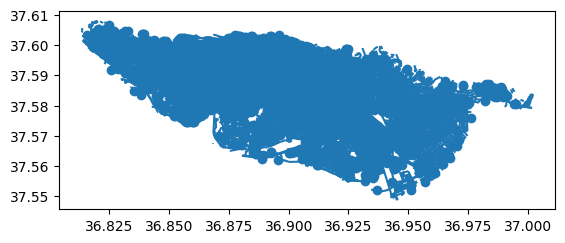

In [37]:
# Basic representation of the data

data_kahramanmaras.plot()
data_kahramanmaras.head()

    13. Kirikhan:

Kırıkhan is a town and district in the Hatay Province of southern Turkey. It's known for its location along the historical Silk Road and its proximity to the Syrian border, which contributes to its diverse cultural heritage. The district is a hub of agriculture and trade, with its economy primarily based on farming, particularly of citrus fruits, olives, and various grains.

Info: https://en.wikipedia.org/wiki/K%C4%B1r%C4%B1khan

Dataset consist of building and transportation data.

In [38]:
#data of Kirikhan

#buildings

path_kirikhan = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_builtUpP_r1_v1.shp'

#area of interest
path_kirikhan_area = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_areaOfInterestA_r1_v1.shp'

#ancillary crisis info
path_kirikhan_anc = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_ancillaryCrisisInfoP_r1_v1.shp'

#transportation/roads
path_kirikhan_transportation = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_transportationL_r1_v1.shp'

#elevation countours
path_kirikhan_phsio = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_physiographyL_r1_v1.shp'


#Water resources
path_kirikhan_hidro = '../data/vectors/KIRIKHAN/V1/EMSR648_AOI18_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI18_GRA_PRODUCT_hydrographyL_r1_v1.shp'


#merging all the data
data_kirikhan = (pd.concat([gpd.read_file(path_kirikhan), gpd.read_file(path_kirikhan_transportation)])
                 .sjoin(gpd.read_file(path_kirikhan_area), how='inner', op='within'))




/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
data_kirikhan['population'], data_kirikhan['income'] =  121028,  6785
#total and second hand sales in the municipality in the last five years
data_kirikhan['total_sales'], data_kirikhan['second_sales'] =  12466, 5881

# percentage of accecing clean city water in the province
data_kirikhan['water_access']= .99
#electric consumption of per capita
data_kirikhan['elec_cons']= 3984
#number of buildings permited
data_kirikhan['building_perm']= 1763
#m2 of the land permited for construction
data_kirikhan['land_permited'] =  2133640
#labour force participation and unemployment rate in the province
data_kirikhan['labour_fource'] = 48.1
data_kirikhan['unemployment'] = 17.1
#agricultural area in decares
data_kirikhan['agricultural'] = 353508523
#expected lifetinme
data_kirikhan['life_time'] = 77.9
#number of hospitals and beds in the province per 100000 people
data_kirikhan['hb_per100000']= 266
#fertility rate in the province
data_kirikhan['fertility']= 2.41
#average household size
data_kirikhan['hh_size']= 3.65

obj_type     name                info        damage_gra  \
0  11-Residential Buildings  Unknown  997-Not Applicable           Damaged   
1  11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   
2  11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   
3  11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   
4  11-Residential Buildings  Unknown  997-Not Applicable  Possibly damaged   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building point          1           2   
1  Photo-interpretation  Building point          1           2   
2  Photo-interpretation  Building point          1           2   
3  Photo-interpretation  Building point          1           2   
4  Photo-interpretation  Building point          1           2   

         cd_value                   geometry  ...  elec_cons building_perm  \
0  Not Applicable  POINT (36.37779 36.52825)  ...       3984          1763   
1  Not Applicable  POINT (36.37682 36.51762)  ...       3984          1763   
2  Not Applicable  POINT (36.37952 36.51417)  ...       3984          1763   
3  Not Applicable  POINT (36.37118 36.51501)  ...       3984          1763   
4  Not Applicable  POINT (36.37047 36.51507)  ...       3984          1763   

  land_permited labour_fource unemployment agricultural  life_time  \
0       2133640          48.1         17.1    353508523       77.9   
1       2133640          48.1         17.1    353508523       77.9   
2       2133640          48.1         17.1    353508523       77.9   
3       2133640          48.1         17.1    353508523       77.9   
4       2133640          48.1         17.1    353508523       77.9   

   hb_per100000  fertility  hh_size  
0           266       2.41     3.65  
1           266       2.41     3.65  
2           266       2.41     3.65  
3           266       2.41     3.65  
4           266       2.41     3.65  

[5 rows x 31 columns]

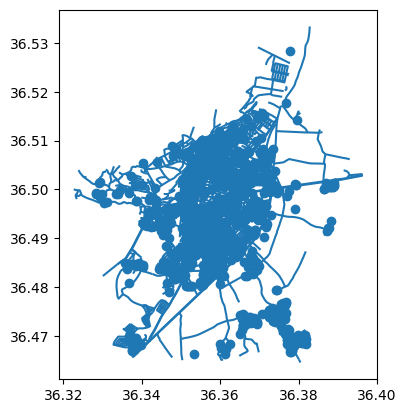

In [40]:
#basic representations

data_kirikhan.plot()
data_kirikhan.head()

    14. Malatya:

Malatya is a large city and the capital of Malatya Province in eastern Turkey. Known for its rich history that dates back to the Hittites, the city is also renowned as a major producer of apricots, particularly the sun-dried variant, which is exported worldwide and is integral to the local economy. Malatya features a mix of modern urban development and historical sites, including the ancient city of Aslantepe, offering a unique blend of the past and the present.

Info: https://en.wikipedia.org/wiki/Malatya_Province 

Data includes buildings and transportation.

In [41]:
# Data for Malatya

#buildings

path_malatya = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_builtUpA_r1_v1.shp'

#area of interest
path_malatya_area = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_areaOfInterestA_r1_v1.shp'
#ancilarry  Crisi Info
path_malatya_anc = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_ancillaryCrisisInfoP_r1_v1.shp'

path_malatya_anc2 = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_ancillaryCrisisInfoA_r1_v1.shp'
#Water resources
path_malatya_hidro1 = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_hydrographyA_r1_v1.shp'
path_malatya_hidro2 = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_hydrographyL_r1_v1.shp'
#Transportation
path_malatya_transportation = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_transportationL_r1_v1.shp'
#Elevation contours
path_malatya_phsio = '../data/vectors/MALATYA/V1_VEC/EMSR648_AOI05_GRA_PRODUCT_r1_VECTORS_v1_vector/EMSR648_AOI05_GRA_PRODUCT_physiographyL_r1_v1.shp'

#merging all data
data_malatya = (pd.concat([gpd.read_file(path_malatya), gpd.read_file(path_malatya_transportation)])
                .sjoin(gpd.read_file(path_malatya_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
#adding statistical data for the province of Malatya

data_malatya['population'], data_malatya['income'] =  853658,  7819
#total and second hand sales in the municipality in the last five years
data_malatya['total_sales'], data_malatya['second_sales'] =  96737, 58495

# percentage of accecing clean city water in the province
data_malatya['water_access']= 1
#electric consumption of per capita
data_malatya['elec_cons']=  2031
#number of buildings permited
data_malatya['building_perm']=  1829
#m2 of the land permited for construction
data_malatya['land_permited'] =  1743251
#labour force participation and unemployment rate in the province
data_malatya['labour_fource'] =  48.3
data_malatya['unemployment'] =  10.2
#agricultural area in decares
data_malatya['agricultural'] =  2729948  
#expected lifetinme
data_malatya['life_time'] =  79.0
#number of hospitals and beds in the province per 100000 people
data_malatya['hb_per100000']=  369
#fertility rate in the province
data_malatya['fertility']=  1.63
#average household size
data_malatya['hh_size']=  3.40


obj_type                   name                info  \
2  11-Residential Buildings  Battalgazi KonaklarÄ±  997-Not Applicable   
3  11-Residential Buildings  Battalgazi KonaklarÄ±  997-Not Applicable   
4  11-Residential Buildings  Battalgazi KonaklarÄ±  997-Not Applicable   
5  11-Residential Buildings  Battalgazi KonaklarÄ±  997-Not Applicable   
6  11-Residential Buildings  Battalgazi KonaklarÄ±  997-Not Applicable   

          damage_gra            det_method        notation  or_src_id  \
2  No visible damage  Photo-interpretation  Building block          1   
3  No visible damage  Photo-interpretation  Building block          1   
4  No visible damage  Photo-interpretation  Building block          1   
5  No visible damage  Photo-interpretation  Building block          1   
6  No visible damage  Photo-interpretation  Building block          1   

   dmg_src_id        cd_value            real  ... elec_cons  building_perm  \
2           2  Not Applicable  Not Applicable  ...      2031           1829   
3           2  Not Applicable  Not Applicable  ...      2031           1829   
4           2  Not Applicable  Not Applicable  ...      2031           1829   
5           2  Not Applicable  Not Applicable  ...      2031           1829   
6           2  Not Applicable  Not Applicable  ...      2031           1829   

  land_permited labour_fource unemployment agricultural life_time  \
2       1743251          48.3         10.2      2729948      79.0   
3       1743251          48.3         10.2      2729948      79.0   
4       1743251          48.3         10.2      2729948      79.0   
5       1743251          48.3         10.2      2729948      79.0   
6       1743251          48.3         10.2      2729948      79.0   

   hb_per100000  fertility  hh_size  
2           369       1.63      3.4  
3           369       1.63      3.4  
4           369       1.63      3.4  
5           369       1.63      3.4  
6           369       1.63      3.4  

[5 rows x 32 columns]

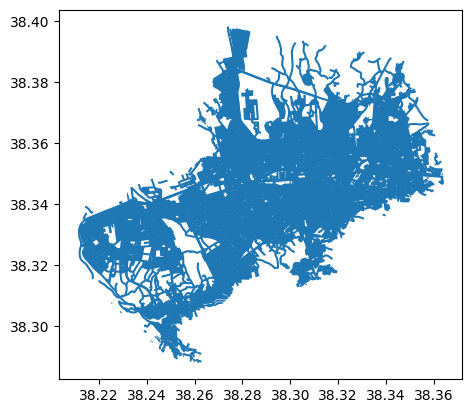

In [43]:
#basic representations of the data

data_malatya.plot()
data_malatya.head()

    15. Nurdagi:

Nurdagi is a town and district located in the Gaziantep Province of southeastern Turkey. Known for its rich agriculture, Nurdagi is situated in a fertile region where various crops such as wheat, barley, lentils, and chickpeas are grown. As of my last update in September 2021, it was a relatively small town that retained a traditional, rural lifestyle, offering a glimpse into the everyday life of southeastern Anatolia. Please consult more recent resources for the most current information.

Info: https://en.wikipedia.org/wiki/Nurda%C4%9F%C4%B1

In dataset aciliary and transportation is represented in different datasets.



In [44]:
#Data of Nurdagi

#buildings

path_nurdagi = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_builtUpA_r1_v1.shp'

#ancillary
path_nurdagi_anc1 = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_ancillaryCrisisInfoA_r1_v1.shp'

path_nurdagi_anc2 = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'

#area of interest
path_nurdagi_area = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_areaOfInterestA_r1_v1.shp'

#water sources
path_nurdagi_hidro = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_hydrographyL_r1_v1.shp'

#contour elevation
path_nurdagi_physio = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_physiographyL_r1_v1.shp'

#transportation datasets.
path_nurdagi_transportation1 = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_transportationL_r1_v1.shp'

path_nurdagi_transportation2 = '../data/vectors/NURDAGI/M1_V1/EMSR648_AOI16_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI16_GRA_MONIT01_transportationP_r1_v1.shp'

#merging all data
data_nurdagi = (pd.concat([gpd.read_file(path_nurdagi), gpd.read_file(path_nurdagi_transportation1),gpd.read_file(path_nurdagi_transportation2)])
                .sjoin(gpd.read_file(path_nurdagi_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
data_nurdagi['population'], data_nurdagi['income'] = 41322, 7819
#total and second hand sales in the municipality in the last five years
data_nurdagi['total_sales'], data_nurdagi['second_sales'] = 3019, 1060

# percentage of accecing clean city water in the province
data_nurdagi['water_access']= 0.99


# percentage of accecing clean city water in the province
data_nurdagi['water_access']= 1
#electric consumption of per capita
data_nurdagi['elec_cons']=  4076
#number of buildings permited
data_nurdagi['building_perm']=  2959
#m2 of the land permited for construction
data_nurdagi['land_permited'] =  3019546
#labour force participation and unemployment rate in the province
data_nurdagi['labour_fource'] =  50
data_nurdagi['unemployment'] =  10.1
#agricultural area in decares
data_nurdagi['agricultural'] =  3466185
#expected lifetinme
data_nurdagi['life_time'] =  76.9
#number of hospitals and beds in the province per 100000 people
data_nurdagi['hb_per100000']=  306
#fertility rate in the province
data_nurdagi['fertility']=  2.47
#average household size
data_nurdagi['hh_size']=  3.9


obj_type     name                info         damage_gra  \
0  11-Residential Buildings  Unknown  997-Not Applicable            Damaged   
1  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
2  11-Residential Buildings  Unknown  997-Not Applicable   Possibly damaged   
3  11-Residential Buildings  Unknown  997-Not Applicable            Damaged   
4  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building block          1           3   
1  Photo-interpretation  Building block          1           3   
2  Photo-interpretation  Building block          1           3   
3  Photo-interpretation  Building block          1           3   
4  Photo-interpretation  Building block          1           3   

         cd_value            real  ... elec_cons  building_perm land_permited  \
0  Not Applicable  Not Applicable  ...      4076           2959       3019546   
1  Not Applicable  Not Applicable  ...      4076           2959       3019546   
2  Not Applicable  Not Applicable  ...      4076           2959       3019546   
3  Not Applicable  Not Applicable  ...      4076           2959       3019546   
4  Not Applicable  Not Applicable  ...      4076           2959       3019546   

  labour_fource unemployment agricultural life_time  hb_per100000  fertility  \
0            50         10.1      3466185      76.9           306       2.47   
1            50         10.1      3466185      76.9           306       2.47   
2            50         10.1      3466185      76.9           306       2.47   
3            50         10.1      3466185      76.9           306       2.47   
4            50         10.1      3466185      76.9           306       2.47   

   hh_size  
0      3.9  
1      3.9  
2      3.9  
3      3.9  
4      3.9  

[5 rows x 32 columns]

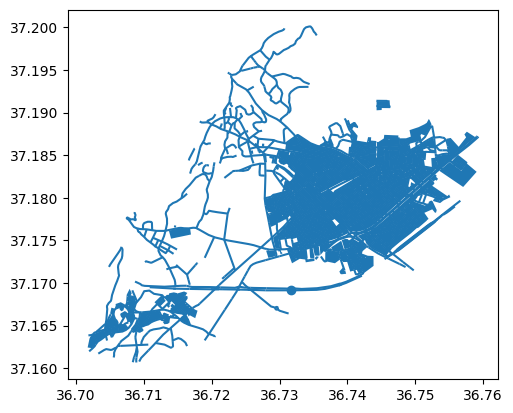

In [46]:
#basic representtions

data_nurdagi.plot()
data_nurdagi.head()

    16.Osmaniye:

Osmaniye is a city in southern Turkey and the capital of Osmaniye Province. Situated in the fertile Çukurova plain, the city is surrounded by mountains and is known for its agricultural production, particularly of peanuts and olives. Osmaniye is also home to several archaeological sites and historic landmarks, including the ancient city of Karatepe, which hosts a significant collection of Hittite relics. The city reflects a mix of the old and the new, with modern developments coexisting with traditional lifestyles and historical heritage. 

Info: https://en.wikipedia.org/wiki/Osmaniye

In dataset facilities are represented in 2 files. Osmaniye data includes transportation, facilities and buildings data.

In [47]:
#dataset for Osmaniye

#buildings
path_osmaniye_b= '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_builtUpA_r1_v2.shp'

#facilities
path_osmaniye_f= '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_facilitiesL_r1_v2.shp'
path_osmaniye_f2= '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_facilitiesL_r1_v2.shp'

#area of interest
path_osmaniye_area = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_areaOfInterestA_r1_v2.shp'
#ancillary crisis info
path_osmaniye_anc = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_ancillaryCrisisInfoP_r1_v2.shp'
#water sources
path_osmaniye_hidro = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_hydrographyL_r1_v2.shp'
# contours elevation
path_osmaniye_physio = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_physiographyL_r1_v2.shp'
#transportation
path_osmaniye_transportation = '../data/vectors/OSMANIYE/M1_V2/EMSR648_AOI06_GRA_MONIT01_r1_RTP01_v2_vector/EMSR648_AOI06_GRA_MONIT01_transportationL_r1_v2.shp'

#merging all data
data_osmaniye = (pd.concat([gpd.read_file(path_osmaniye_b), gpd.read_file(path_osmaniye_f), gpd.read_file(path_osmaniye_f2), gpd.read_file(path_osmaniye_transportation)]).
                 sjoin(gpd.read_file(path_osmaniye_area), how='inner', op='within'))


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [48]:
#additional data for Osmaniye
#population and income
data_osmaniye['population'], data_osmaniye['income'] =  285430, 6256
#total and second hand sales in the municipality in the last five years
data_osmaniye['total_sales'], data_osmaniye['second_sales'] =  32782, 19933


# percentage of accecing clean city water in the province
data_osmaniye['water_access']= 0.95
#electric consumption of per capita
data_osmaniye['elec_cons']= 7413

#number of buildings permited
data_osmaniye['building_perm']= 583
#m2 of the land permited for construction
data_osmaniye['land_permited'] =  782505
#labour force participation and unemployment rate in the province
data_osmaniye['labour_fource'] = 48.1
data_osmaniye['unemployment'] = 17.1
#agricultural area in decares
data_osmaniye['agricultural'] = 1233061
#expected lifetinme
data_osmaniye['life_time'] = 78
#number of hospitals and beds in the province per 100000 people
data_osmaniye['hb_per100000']= 246
#fertility rate in the province
data_osmaniye['fertility']= 1.92
#average household size
data_osmaniye['hh_size']= 3.46



obj_type     name                info         damage_gra  \
0  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
1  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
2  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
3  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
4  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building block        994           3   
1  Photo-interpretation  Building block        994           3   
2  Photo-interpretation  Building block        994           3   
3  Photo-interpretation  Building block        994           3   
4  Photo-interpretation  Building block        994           3   

         cd_value            real  ... elec_cons  building_perm land_permited  \
0  Not Applicable  Not Applicable  ...      7413            583        782505   
1  Not Applicable  Not Applicable  ...      7413            583        782505   
2  Not Applicable  Not Applicable  ...      7413            583        782505   
3  Not Applicable  Not Applicable  ...      7413            583        782505   
4  Not Applicable  Not Applicable  ...      7413            583        782505   

  labour_fource unemployment agricultural life_time  hb_per100000  fertility  \
0          48.1         17.1      1233061        78           246       1.92   
1          48.1         17.1      1233061        78           246       1.92   
2          48.1         17.1      1233061        78           246       1.92   
3          48.1         17.1      1233061        78           246       1.92   
4          48.1         17.1      1233061        78           246       1.92   

   hh_size  
0     3.46  
1     3.46  
2     3.46  
3     3.46  
4     3.46  

[5 rows x 32 columns]

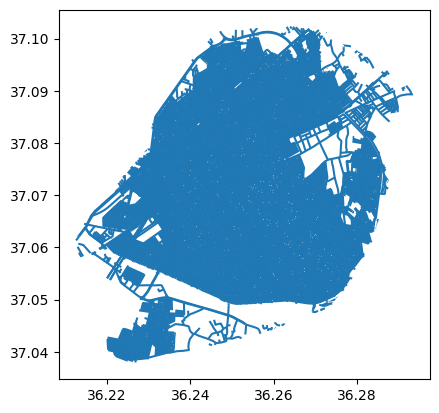

In [49]:
#Basic Representations

data_osmaniye.plot()
data_osmaniye.head()


    17. Pazarcik:

Pazarcık is a town and district located in Kahramanmaraş Province in southern Turkey. Known for its agricultural industry, the district is primarily involved in the cultivation of crops like wheat, barley, and corn. Its name, which translates to "little market" in Turkish, hints at its historical roots as a trading center. Pazarcık has a mix of rural and urban areas, offering a glimpse into the region's traditional lifestyle alongside modern development. 

Info: https://en.wikipedia.org/wiki/Pazarc%C4%B1k

We have facilities representes in 2 different file, buildings and transportation.

In [50]:
#Pazarcik Data
#buildings

path_pazarcik_b = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_builtUpP_r1_v1.shp'

#facilities
path_pazarcik_f = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_facilitiesA_r1_v1.shp'
path_pazarcik_f2 = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_facilitiesL_r1_v1.shp'

#area of interest
path_pazarcik_area = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_areaOfInterestA_r1_v1.shp'
#ancillary
path_pazarcik_anc = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_ancillaryCrisisInfoP_r1_v1.shp'
#water sources
path_pazarcik_hidro = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_hydrographyA_r1_v1.shp'

#contour elevations
path_pazarcik_physio = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_physiographyL_r1_v1.shp'

#transportation
path_pazarcik_transportation = '../data/vectors/PAZARCIK/M1_V1/EMSR648_AOI08_GRA_MONIT01_r1_RTP01_v1_vector/EMSR648_AOI08_GRA_MONIT01_transportationL_r1_v1.shp'

#merging all data
data_pazarcik = (pd.concat([gpd.read_file(path_pazarcik_b), gpd.read_file(path_pazarcik_f), gpd.read_file(path_pazarcik_f2), gpd.read_file(path_pazarcik_transportation)])
                 .sjoin(gpd.read_file(path_pazarcik_area), how='inner', op='within'))




/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [51]:
#additional data for Pazarcik
#population and income

data_pazarcik['population'], data_pazarcik['income'] =  70173,  5997
#total and second hand sales in the municipality in the last five years
data_pazarcik['total_sales'], data_pazarcik['second_sales'] = 5747, 1932


# percentage of accecing clean city water in the province
data_pazarcik['water_access']= 0.95
#electric consumption of per capita
data_pazarcik['elec_cons']= 4343
#number of buildings permited
data_pazarcik['building_perm']= 1528
#m2 of the land permited for construction in province
data_pazarcik['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_pazarcik['labour_fource'] = 48.1
data_pazarcik['unemployment'] = 17.1

#agricultural area in decares
data_pazarcik['agricultural'] = 3535085
#expected lifetinme
data_pazarcik['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_pazarcik['hb_per100000']= 256
#fertility rate in the province
data_pazarcik['fertility']= 1.99
#average household size
data_pazarcik['hh_size']= 3.68



obj_type     name  \
0      11-Residential Buildings  Unknown   
1      11-Residential Buildings  Unknown   
2      11-Residential Buildings  Unknown   
3  12-Non-residential Buildings  Unknown   
4      11-Residential Buildings  Unknown   

                                      info damage_gra            det_method  \
0                       997-Not Applicable  Destroyed  Photo-interpretation   
1                       997-Not Applicable  Destroyed  Photo-interpretation   
2                       997-Not Applicable  Destroyed  Photo-interpretation   
3  125-Industrial buildings and warehouses  Destroyed  Photo-interpretation   
4                       997-Not Applicable  Destroyed  Photo-interpretation   

         notation  or_src_id  dmg_src_id        cd_value  \
0  Building point          3           3  Not Applicable   
1  Building point          3           3  Not Applicable   
2  Building point          3           3  Not Applicable   
3  Building point          3           3  Not Applicable   
4  Building point          2           2  Not Applicable   

                    geometry  ...  elec_cons building_perm land_permited  \
0  POINT (37.29024 37.47958)  ...       4343          1528       2222311   
1  POINT (37.29125 37.48053)  ...       4343          1528       2222311   
2  POINT (37.29074 37.48523)  ...       4343          1528       2222311   
3  POINT (37.28594 37.47705)  ...       4343          1528       2222311   
4  POINT (37.29187 37.48895)  ...       4343          1528       2222311   

  labour_fource unemployment agricultural  life_time  hb_per100000  fertility  \
0          48.1         17.1      3535085       79.2           256       1.99   
1          48.1         17.1      3535085       79.2           256       1.99   
2          48.1         17.1      3535085       79.2           256       1.99   
3          48.1         17.1      3535085       79.2           256       1.99   
4          48.1         17.1      3535085       79.2           256       1.99   

   hh_size  
0     3.68  
1     3.68  
2     3.68  
3     3.68  
4     3.68  

[5 rows x 31 columns]

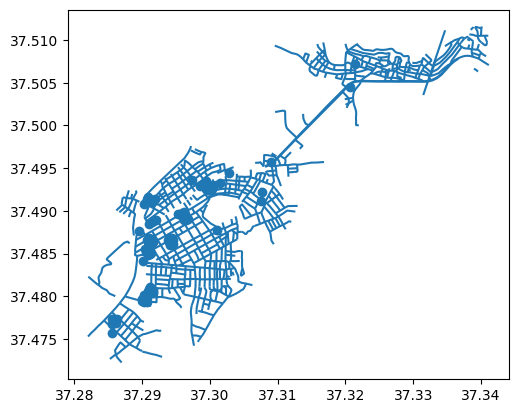

In [52]:
#Basic representation of the data

data_pazarcik.plot()
data_pazarcik.head()

    18.Sanliurfa:

Şanlıurfa, often simply known as Urfa, is a city in southeastern Turkey, steeped in history and cultural heritage. The city is believed to be one of the oldest continuously inhabited cities in the world, with a history that dates back thousands of years to the time of the ancient civilizations of Mesopotamia. It's also traditionally associated with biblical history, being known as the "City of Prophets," with local lore identifying it as the birthplace of Abraham. Şanlıurfa is renowned for its unique cuisine, impressive architecture, including the old town with its traditional 'hans' and bazaars, and significant archaeological sites like Göbekli Tepe, often considered the world's oldest temple.

Info: https://en.wikipedia.org/wiki/Urfa

In sanliurfa data transportation in 2 different files. we will use building, facilities and transportation data

In [53]:
#Sanliurfa data
#buildings

path_sanliurfa_b = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_builtUpA_r1_v1.shp'
#facilities
path_sanliurfa_f = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_facilitiesA_r1_v1.shp'
#area of interest
path_sanliurfa_area = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_areaOfInterestA_r1_v1.shp'
#transportation
path_sanliurfa_transportation1 = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_transportationL_r1_v1.shp'

path_sanliurfa_transportation2 = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_transportationA_r1_v1.shp'
#water sources
path_sanliurfa_hidro1 = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_hydrographyA_r1_v1.shp'

path_sanliurfa_hidro2 = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_hydrographyL_r1_v1.shp'

#elevation
path_sanliurfa_physio = '../data/vectors/SANLIURFA/V1/EMSR648_AOI07_GRA_PRODUCT_r1_RTP01_v1_vector/EMSR648_AOI07_GRA_PRODUCT_physiographyL_r1_v1.shp'

#merging all the data
data_sanliurfa = (pd.concat([gpd.read_file(path_sanliurfa_b), gpd.read_file(path_sanliurfa_f), gpd.read_file(path_sanliurfa_transportation1), gpd.read_file(path_sanliurfa_transportation2)])
                  .sjoin(gpd.read_file(path_sanliurfa_area), how='inner', op='within'))




/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
#additional information about the province
#income and population

data_sanliurfa['population'], data_sanliurfa['income'] =  2170110,  3012
#total and second hand sales in the municipality in the last five years
data_sanliurfa['total_sales'], data_sanliurfa['second_sales'] =  177626, 99010

# percentage of accecing clean city water in the province
data_sanliurfa['water_access']= 0.95
#electric consumption of per capita
data_sanliurfa['elec_cons']=  1631
#number of buildings permited
data_sanliurfa['building_perm']=  978
#m2 of the land permited for construction
data_sanliurfa['land_permited'] =  1189247
#labour force participation and unemployment rate in the province
data_sanliurfa['labour_fource'] =  40.6
data_sanliurfa['unemployment'] =  15.0
#agricultural area in decares
data_sanliurfa['agricultural'] =  10445551
#expected lifetinme
data_sanliurfa['life_time'] =  77.7
#number of hospitals and beds in the province per 100000 people
data_sanliurfa['hb_per100000']=  193
#fertility rate in the province
data_sanliurfa['fertility']=  3.81
#average household size
data_sanliurfa['hh_size']=  5.12

obj_type     name                info         damage_gra  \
0  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
1  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
2  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
3  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   
4  11-Residential Buildings  Unknown  997-Not Applicable  No visible damage   

             det_method        notation  or_src_id  dmg_src_id  \
0  Photo-interpretation  Building block          1           2   
1  Photo-interpretation  Building block          1           2   
2  Photo-interpretation  Building block          1           2   
3  Photo-interpretation  Building block          1           2   
4  Photo-interpretation  Building block          1           2   

         cd_value            real  ... elec_cons  building_perm land_permited  \
0  Not Applicable  Not Applicable  ...      1631            978       1189247   
1  Not Applicable  Not Applicable  ...      1631            978       1189247   
2  Not Applicable  Not Applicable  ...      1631            978       1189247   
3  Not Applicable  Not Applicable  ...      1631            978       1189247   
4  Not Applicable  Not Applicable  ...      1631            978       1189247   

  labour_fource unemployment agricultural life_time  hb_per100000  fertility  \
0          40.6         15.0     10445551      77.7           193       3.81   
1          40.6         15.0     10445551      77.7           193       3.81   
2          40.6         15.0     10445551      77.7           193       3.81   
3          40.6         15.0     10445551      77.7           193       3.81   
4          40.6         15.0     10445551      77.7           193       3.81   

   hh_size  
0     5.12  
1     5.12  
2     5.12  
3     5.12  
4     5.12  

[5 rows x 32 columns]

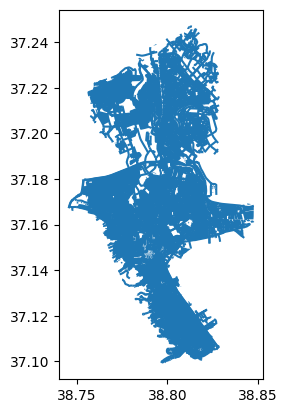

In [55]:
#basic representation of the data   

data_sanliurfa.plot()
data_sanliurfa.head()

    19.Turkoglu:

Turkoğlu is a town and district in the Kahramanmaraş Province of southern Turkey. It's known for its agriculture, particularly the production of cereals, olive oil, and a variety of fruits and vegetables. The district's relatively mild Mediterranean climate contributes to its agricultural productivity.

Info: https://en.wikipedia.org/wiki/T%C3%BCrko%C4%9Flu

In [56]:
# Data of the Turkoglu

#buildings
path_turkoglu_b = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_builtUpA_r1_v2.shp'
#facilities
path_turkoglu_f = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_facilitiesA_r1_v2.shp'
#area of interest
path_turkoglu_area = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_areaOfInterestA_r1_v2.shp'
#anclilarry
path_turkoglu_anc1 = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_ancillaryCrisisInfoP_r1_v2.shp'

path_turkoglu_anc2 = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_ancillaryCrisisInfoA_r1_v2.shp'

#water sources
path_turkoglu_hidro = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_hydrographyL_r1_v2.shp'

#transportation
path_turkoglu_transportation = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_transportationL_r1_v2.shp'
#contour elevation
path_turkoglu_physio = '../data/vectors/TURKOGLU/V2/EMSR648_AOI17_GRA_PRODUCT_r1_RTP01_v2_vector/EMSR648_AOI17_GRA_PRODUCT_physiographyL_r1_v2.shp'

#merging all the data
data_turkoglu = (pd.concat([gpd.read_file(path_turkoglu_b), gpd.read_file(path_turkoglu_f), gpd.read_file(path_turkoglu_transportation)])
                 .sjoin(gpd.read_file(path_turkoglu_area), how='inner', op='within'))

/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
# statistical data of the province
#income and population of the province

data_turkoglu['population'], data_turkoglu['income'] =  78976,  5997
#total and second hand sales in the municipality in the last five years
data_turkoglu['total_sales'], data_turkoglu['second_sales'] = 1938, 536

# percentage of accecing clean city water in the province
data_turkoglu['water_access']= 0.95
#electric consumption of per capita
data_turkoglu['elec_cons']= 4343
#number of buildings permited
data_turkoglu['building_perm']= 1528
#m2 of the land permited for construction in province
data_turkoglu['land_permited'] = 2222311
#labour force participation and unemployment rate in the province
data_turkoglu['labour_fource'] = 48.1
data_turkoglu['unemployment'] = 17.1

#agricultural area in decares
data_turkoglu['agricultural'] = 3535085
#expected lifetinme
data_turkoglu['life_time'] = 79.2
#number of hospitals and beds in the province per 100000 people
data_turkoglu['hb_per100000']= 256
#fertility rate in the province
data_turkoglu['fertility']= 1.99
#average household size
data_turkoglu['hh_size']= 3.68

obj_type     name                       info  \
0  12-Non-residential Buildings  Unknown  1251-Industrial buildings   
1      11-Residential Buildings  Unknown         997-Not Applicable   
2      11-Residential Buildings  Unknown         997-Not Applicable   
3      11-Residential Buildings  Unknown         997-Not Applicable   
4      11-Residential Buildings  Unknown         997-Not Applicable   

          damage_gra            det_method        notation  or_src_id  \
0            Damaged  Photo-interpretation  Building block          1   
1  No visible damage  Photo-interpretation  Building block          1   
2  No visible damage  Photo-interpretation  Building block          1   
3  No visible damage  Photo-interpretation  Building block          1   
4  No visible damage  Photo-interpretation  Building block          1   

   dmg_src_id        cd_value            real  ... elec_cons  building_perm  \
0           2  Not Applicable  Not Applicable  ...      4343           1528   
1           2  Not Applicable  Not Applicable  ...      4343           1528   
2           2  Not Applicable  Not Applicable  ...      4343           1528   
3           2  Not Applicable  Not Applicable  ...      4343           1528   
4           2  Not Applicable  Not Applicable  ...      4343           1528   

  land_permited labour_fource unemployment agricultural life_time  \
0       2222311          48.1         17.1      3535085      79.2   
1       2222311          48.1         17.1      3535085      79.2   
2       2222311          48.1         17.1      3535085      79.2   
3       2222311          48.1         17.1      3535085      79.2   
4       2222311          48.1         17.1      3535085      79.2   

   hb_per100000  fertility  hh_size  
0           256       1.99     3.68  
1           256       1.99     3.68  
2           256       1.99     3.68  
3           256       1.99     3.68  
4           256       1.99     3.68  

[5 rows x 32 columns]

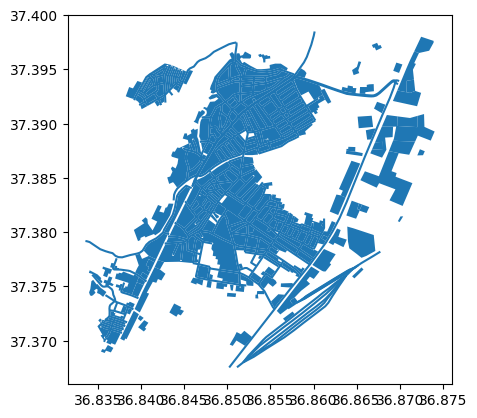

In [58]:
# Basic representationsof the data

data_turkoglu.plot()
data_turkoglu.head()


So far, we have built foundational data for every unit in the dataset. The data can be combined using the 'concat' function along the columns.

obj_type     name                       info  \
0      11-Residential Buildings  Unknown         997-Not Applicable   
1      11-Residential Buildings  Unknown         997-Not Applicable   
2  12-Non-residential Buildings  Unknown  1251-Industrial buildings   
3  12-Non-residential Buildings  Unknown  1251-Industrial buildings   
4      11-Residential Buildings  Unknown         997-Not Applicable   

          damage_gra            det_method        notation  or_src_id  \
0  No visible damage  Photo-interpretation  Building block          1   
1  No visible damage  Photo-interpretation  Building block          1   
2  No visible damage  Photo-interpretation  Building block          1   
3  No visible damage  Photo-interpretation  Building block          1   
4  No visible damage  Photo-interpretation  Building block          1   

   dmg_src_id        cd_value            real  ... elec_cons  building_perm  \
0           3  Not Applicable  Not Applicable  ...      2060            810   
1           3  Not Applicable  Not Applicable  ...      2060            810   
2           3  Not Applicable  Not Applicable  ...      2060            810   
3           3  Not Applicable  Not Applicable  ...      2060            810   
4           3  Not Applicable  Not Applicable  ...      2060            810   

  land_permited labour_fource unemployment agricultural life_time  \
0        695718          50.0         10.1      2336012      79.7   
1        695718          50.0         10.1      2336012      79.7   
2        695718          50.0         10.1      2336012      79.7   
3        695718          50.0         10.1      2336012      79.7   
4        695718          50.0         10.1      2336012      79.7   

   hb_per100000  fertility  hh_size  
0           222       2.36      4.0  
1           222       2.36      4.0  
2           222       2.36      4.0  
3           222       2.36      4.0  
4           222       2.36      4.0  

[5 rows x 32 columns]

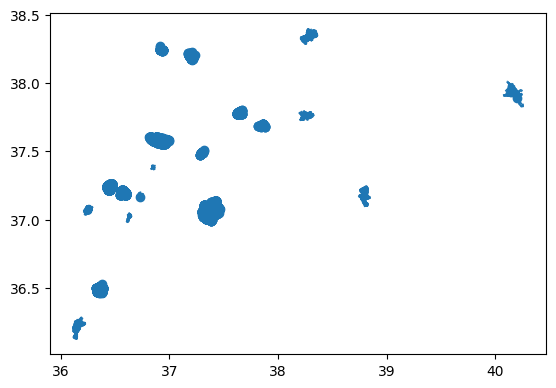

In [59]:
# Concataneting all data from different cities.

data = pd.concat([data_adiyaman, data_afsin, data_antakya, data_bahce, data_diyarbakir,
                  data_duzici, data_elbistan, data_erdemoglu,
                  data_gaziantep, data_golbasi, data_islahiye,
                  data_kahramanmaras, data_kirikhan, data_malatya, data_nurdagi, data_osmaniye,
                  data_pazarcik, data_sanliurfa, data_turkoglu])


#basic representations
data.plot()

data.head()

    Anciliaty information: 

Anciliary points tend to cluster around areas close to the city center. Nevertheless, as we have observed in previous local analyses, some places lack this information. I aim to incorporate this data into the dataset since it holds significant importance to the buildings. We will carry out this operation on the entire dataset because in some smaller cities or villages, camping in the neighboring city could be more logical. Later, 

<AxesSubplot: >

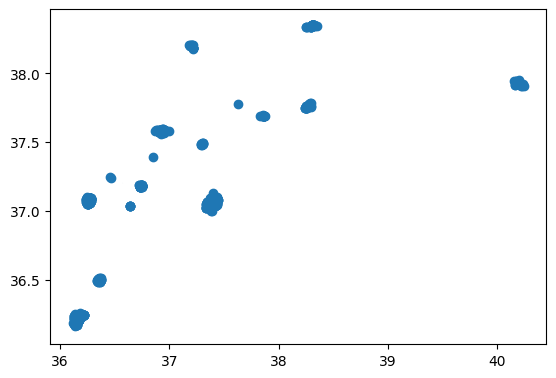

In [60]:
#concatanation of the ancillary datasets
data_anc = pd.concat([gpd.read_file(path_adiyaman_anc), gpd.read_file(path_adiyaman_anc2), gpd.read_file(path_antakya_anc1), gpd.read_file(path_antakya_anc2),
                      gpd.read_file(path_bahce_anc1), gpd.read_file(path_diyarbakir_anc), gpd.read_file(path_duzici_anc1), gpd.read_file(path_duzici_anc2),
                      gpd.read_file(path_elbistan_anc), gpd.read_file(path_erdemoglu_anc), gpd.read_file(path_gaziantep_anc),
                      gpd.read_file(path_golbasi_anc), gpd.read_file(path_islahiye_anc1), gpd.read_file(path_islahiye_anc2),
                      gpd.read_file(path_kahramanmaras_anc),gpd.read_file(path_kirikhan_anc), gpd.read_file(path_malatya_anc), 
                      gpd.read_file(path_nurdagi_anc1), gpd.read_file(path_nurdagi_anc2),gpd.read_file(path_osmaniye_anc), 
                      gpd.read_file(path_pazarcik_anc), gpd.read_file(path_turkoglu_anc1), gpd.read_file(path_turkoglu_anc2)])
data_anc.plot()


                   


    Elevation Contour- Physiography:

This data is used to understand if the height of the building matters in to the damage. In later steps, with balltree method we will try to understand how much height the buildings have.

obj_type     name  elev        notation  or_src_id  \
0  CA010-Elevation Contour  Unknown   870  Not Applicable        984   
1  CA010-Elevation Contour  Unknown   990  Not Applicable        984   
2  CA010-Elevation Contour  Unknown   960  Not Applicable        984   
3  CA010-Elevation Contour  Unknown   870  Not Applicable        984   
4  CA010-Elevation Contour  Unknown   810  Not Applicable        984   

                                            geometry  
0  LINESTRING (38.27222 37.79194, 38.27222 37.791...  
1  MULTILINESTRING ((38.25278 37.79194, 38.25278 ...  
2  MULTILINESTRING ((38.25514 37.79056, 38.25500 ...  
3  LINESTRING (38.27472 37.78972, 38.27472 37.789...  
4  MULTILINESTRING ((38.28903 37.78861, 38.28889 ...

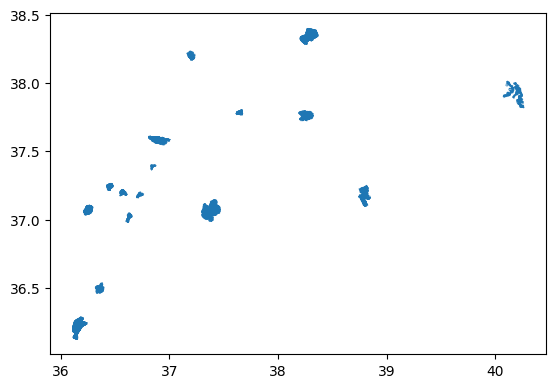

In [79]:
#concatanating all the physiography data
data_physio = pd.concat ([gpd.read_file(path_adiyaman_phisio), gpd.read_file(path_antakya_phisio), gpd.read_file(path_bahce_phisio),
                          gpd.read_file(path_diyarbakir_phisio), gpd.read_file(path_duzici_phisio), gpd.read_file(path_elbistan_phisio),
                          gpd.read_file(path_gaziantep_phisio), gpd.read_file(path_golbasi_phisio),
                          gpd.read_file(path_islahiye_physio), gpd.read_file(path_kahramanmaras_phisio), gpd.read_file(path_kirikhan_phsio),
                          gpd.read_file(path_malatya_phsio), gpd.read_file(path_nurdagi_physio), gpd.read_file(path_osmaniye_physio),
                          gpd.read_file(path_sanliurfa_physio), gpd.read_file(path_turkoglu_physio)])

data_physio.plot()
data_physio.head()

    Water Sources:

The Copernicus Disaster dataset also encompasses information on water sources, referred to as "Hydrography". This is a geographic variable that could potentially influence building safety. Therefore, it's essential that we factor this into our considerations.We might consider using the distance to water resources as a variable in our analysis.

<AxesSubplot: >

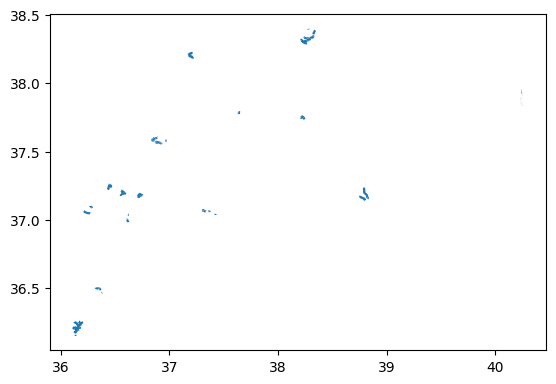

In [62]:
# Concatanating water source data

data_hidro = pd.concat([gpd.read_file(path_adiyaman_hydro), gpd.read_file(path_antakya_hidro),
                        gpd.read_file(path_bahce_hidro), gpd.read_file(path_diyarbakir_hidro), gpd.read_file(path_duzici_hidro),
                        gpd.read_file(path_elbistan_hidro), gpd.read_file(path_gaziantep_hidro),
                        gpd.read_file(path_golbasi_hidro), gpd.read_file(path_islahiye_hidro), gpd.read_file(path_kahramanmaras_hidroA),
                        gpd.read_file(path_kahramanmaras_hidroL),gpd.read_file(path_kirikhan_hidro),gpd.read_file(path_malatya_hidro1),
                        gpd.read_file(path_malatya_hidro2), gpd.read_file(path_nurdagi_hidro), gpd.read_file(path_osmaniye_hidro),
                        gpd.read_file(path_sanliurfa_hidro1), gpd.read_file(path_sanliurfa_hidro2)])

data_hidro.plot()

    BallTree Method:

In order to find Euclidian Distances, we have used a Balltree method in the following function. 


A Ball Tree is a type of data structure that is used in machine learning and data analysis for efficiently finding nearest neighbors in a multidimensional space. It is particularly useful for applications such as clustering, outlier detection, and density estimation.

The basic idea behind a Ball Tree is to partition data into nested hyper-spheres (or "balls"). This allows the algorithm to quickly eliminate large portions of the data when searching for nearest neighbors. The tree structure encapsulates an inherent recursive partitioning of the space: each node of the tree splits the data into two sets, each associated with a different child node.

The process of building a Ball Tree involves the following steps:

1. Select a point from the dataset as the center of a ball and include as many points as possible inside the ball, given some radius constraint.
2. If the ball contains more than one point, create child balls within the parent ball such that each child ball contains a subset of the points in the parent ball, and the child balls do not overlap.
3. Repeat the process for each child ball until each ball contains only one point, or until a stopping condition is met (like a maximum depth or a minimum number of points per ball).

When it comes to querying the Ball Tree for nearest neighbors, the tree structure enables a quick, efficient search. When considering a given ball at a node in the tree, if the closest point in the ball is further than the current closest known point, we know that the ball (and all its child nodes) need not be considered, thus pruning large parts of the search space.


In [63]:
from sklearn.neighbors import BallTree

def add_nearest_distance(data, data_reference, lat_column='latitude', lon_column='longitude', new_column='nearest_distance', metric='euclidean'):
    """A funcion that adds a column to a DataFrame with the euclidian distance to the nearest point in another DataFrame."""
    # Extract latitude and longitude from geometry if not already present
    for df in [data, data_reference]:
        if lat_column not in df.columns or lon_column not in df.columns:
            if 'geometry' in df.columns:
                df[lon_column] = df['geometry'].centroid.x
                df[lat_column] = df['geometry'].centroid.y
            else:
                raise ValueError(f"Both '{lat_column}' and '{lon_column}' are missing and there is no 'geometry' column to calculate them from.")

    # Create a BallTree with the reference data
    tree = BallTree(data_reference[[lat_column, lon_column]].values, metric=metric)

    # Query the BallTree for the nearest point in data_reference for each point in data
    dist, ind = tree.query(data[[lat_column, lon_column]].values, k=1) # k=1 means find only the nearest point

    # 'dist' will contain the distances to the nearest points. We flatten it before adding to the DataFrame
    # These distances are in the same units as the latitude and longitude
    data[new_column] = dist.flatten()

    return data




    Fault Information & Distance to the Disaster: 

Information regarding fault lines is anticipated to be of utmost importance. Buildings situated near these faults are highly susceptible to earthquake damage, as these locations serve as conduits for seismic energy transmission.



In [64]:

# Reading Earthquakes data
data_earthquakes = pd.read_csv('../data/archive/Earthquakes.csv')
#changing Date column to datetime
data_earthquakes['Date'] = pd.to_datetime(data_earthquakes['Date'])

#filtering the movements in disaster period on 06/02/2023
data_earthquakes = data_earthquakes[data_earthquakes['Date'] > '2023-02-06 00:00:00']

#in order to be used by the add_nearest_distance function, we need to rename the columns

data_earthquakes.rename(columns={'Latitude':'latitude', 'Longitude':'longitude'}, inplace=True)

In [65]:
#reading Faults shape file and converting it to a dataframe

data_faults = gpd.read_file('../data/Fault_shp/Diri Faylar.shp')


In [66]:
# adding nearest distance to water source and camping area using datasets
data = add_nearest_distance(data, data_hidro, new_column='nearest_water_source_distance')
data = add_nearest_distance(data, data_anc, new_column='nearest_camping_distance')
data= add_nearest_distance(data, data_earthquakes, new_column='nearest_earthquake_distance')
data = add_nearest_distance(data, data_faults, new_column='nearest_fault_distance')

/tmp/ipykernel_38946/427067034.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df[lon_column] = df['geometry'].centroid.x
/tmp/ipykernel_38946/427067034.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df[lat_column] = df['geometry'].centroid.y
/tmp/ipykernel_38946/427067034.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df[lon_column] = df['geometry'].centroid.x
/tmp/ipykernel_38946/427067034.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS

Trying to find the height of the points require a different operation that we would like to do only ones. With the below code we are able to find the nearest elevation point to have a aproximation to the heights of the buildings from sea level. As we have checked before, not all the locals have this information and since the elevation changed in every 10 meters, not all the buildings would be on a line.

In [82]:


# Reset indices of the DataFrames
data = data.reset_index(drop=True)
data_physio = data_physio.reset_index(drop=True)

# Assuming data_physio is LineString GeoDataFrame
data_physio['line'] = data_physio['geometry']

for i in data.index:
    # Get the single building point
    building_point = data.at[i, 'geometry']
    # Store all distances
    all_dists = []
    # Iterate over physio data
    for j in data_physio.index:
        # Get the line
        line = data_physio.at[j, 'line']
        # Find the nearest point on the line to building_point
        nearest_geom = nearest_points(building_point, line)
        # Calculate the distance
        dist = building_point.distance(nearest_geom[1])
        all_dists.append((j, dist))

    # Find the minimum distance
    idxmin = min(all_dists, key=lambda x:x[1])[0]
    
    # Assign the 'elev' value of the closest physiography point to the 'elev' of this building point
    data.at[i, 'elev'] = data_physio.at[idxmin, 'elev']


/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/home/lapita/anaconda3/envs/tfm/lib/python3.9/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)


obj_type     name                       info  \
0      11-Residential Buildings  Unknown         997-Not Applicable   
1      11-Residential Buildings  Unknown         997-Not Applicable   
2  12-Non-residential Buildings  Unknown  1251-Industrial buildings   
3  12-Non-residential Buildings  Unknown  1251-Industrial buildings   
4      11-Residential Buildings  Unknown         997-Not Applicable   

          damage_gra            det_method        notation  or_src_id  \
0  No visible damage  Photo-interpretation  Building block          1   
1  No visible damage  Photo-interpretation  Building block          1   
2  No visible damage  Photo-interpretation  Building block          1   
3  No visible damage  Photo-interpretation  Building block          1   
4  No visible damage  Photo-interpretation  Building block          1   

   dmg_src_id        cd_value            real  ... hb_per100000  fertility  \
0           3  Not Applicable  Not Applicable  ...          222       2.36   
1           3  Not Applicable  Not Applicable  ...          222       2.36   
2           3  Not Applicable  Not Applicable  ...          222       2.36   
3           3  Not Applicable  Not Applicable  ...          222       2.36   
4           3  Not Applicable  Not Applicable  ...          222       2.36   

  hh_size  longitude   latitude nearest_water_source_distance  \
0     4.0  38.314252  37.768867                      0.077874   
1     4.0  38.313284  37.768690                      0.076904   
2     4.0  38.318013  37.768612                      0.081336   
3     4.0  38.318677  37.768575                      0.081953   
4     4.0  38.312542  37.768514                      0.076146   

  nearest_camping_distance  nearest_earthquake_distance  \
0                 0.020232                     0.097845   
1                 0.019284                     0.097004   
2                 0.023588                     0.100527   
3                 0.024196                     0.101013   
4                 0.018542                     0.096334   

   nearest_fault_distance   elev  
0                0.016935  660.0  
1                0.017440  660.0  
2                0.014585  660.0  
3                0.014241  660.0  
4                0.017826  660.0  

[5 rows x 39 columns]

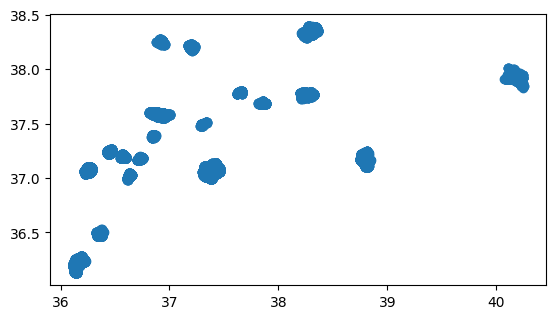

In [83]:
# representation of final dataset
data.plot()
data.head()

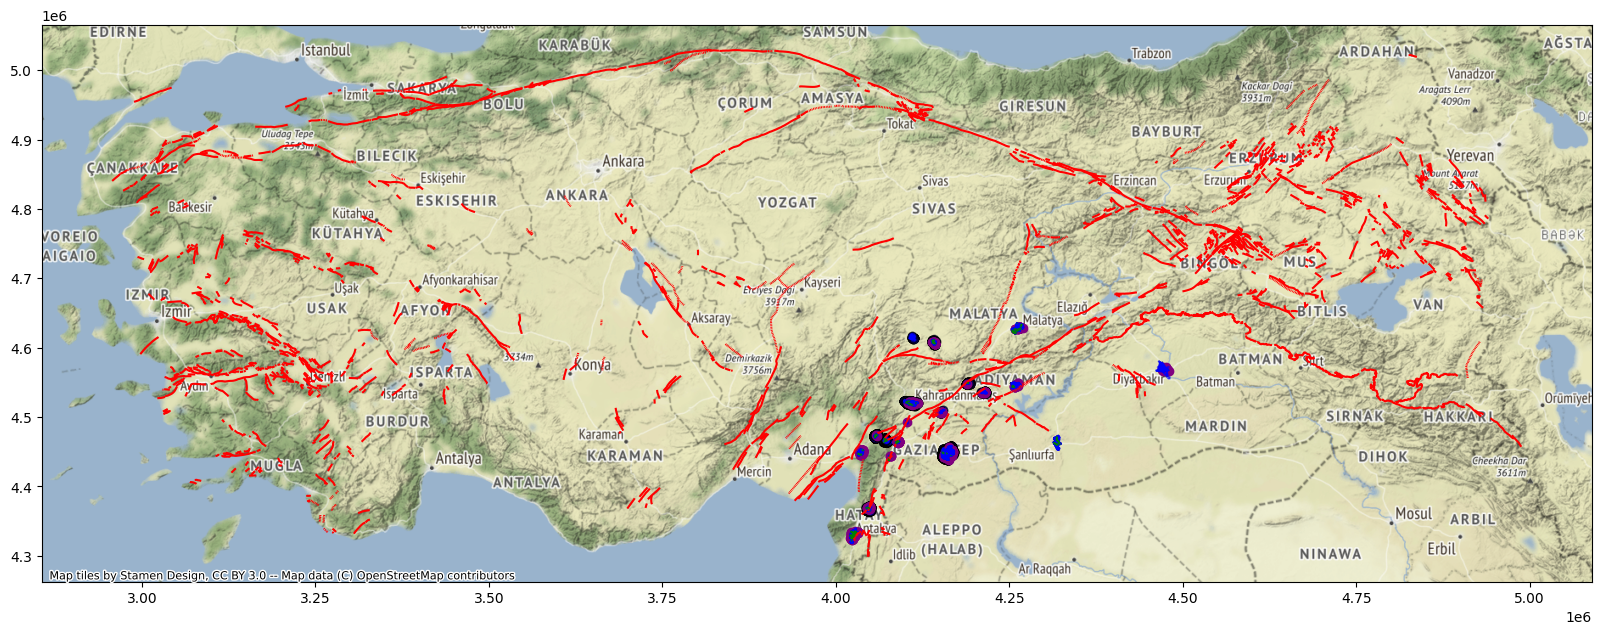

In [77]:
# demonstrating data, faults, water sources and anciliary datas on a base map

# Convert your data to Web Mercator
data = data.to_crs(epsg=3857)
data_faults = data_faults.to_crs(epsg=3857)
data_hidro = data_hidro.to_crs(epsg=3857)
data_anc = data_anc.to_crs(epsg=3857)

# Create a subplot
fig, ax = plt.subplots(figsize=(20, 20))

# Plotting the 'data' GeoDataFrame
data.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')

# Plotting the 'data_faults' GeoDataFrame
data_faults.plot(ax=ax, color='red')

# Plotting the 'data_hidro' GeoDataFrame
data_hidro.plot(ax=ax, color='green')

# Plotting the 'data_anc' GeoDataFrame
data_anc.plot(ax=ax, color='purple')

# Add a basemap.
ctx.add_basemap(ax)

plt.show()


As can be observed on the map, the indicated buildings are situated near the fault lines, which likely contributed to the damage incurred during the disaster. Concurrently, the data on the fault lines reveal other high-risk areas beyond the zone that was damaged.

    Saving the files for other notebooks:


Now we save the data in the processed folder. Since the data is now large with geometric information, it will be saved both in geojson and pickle format so that we can open in the other notebooks as well.

In [85]:

# If the directory does not exist, create it
if not os.path.exists('../data/processed'):
    os.makedirs('../data/processed')    


In [86]:
# saving in geojson format (takes a while around 30 seconds)
# Infer the schema from your GeoDataFrame
schema = gpd.io.file.infer_schema(data)

with fiona.open("../data/processed/dataset.geojson", 'w', 
                driver='GeoJSON', 
                crs='EPSG:4326', 
                schema=schema) as file:
    # Iterate over each row (record) in the GeoDataFrame
    for record in data.iterfeatures():
        file.write(record)

In [87]:
# incase of problems saving to the pickle file to be called from other notebooks.
with open('../data/processed/dataset.pickle', 'wb') as f:
    pickle.dump(data, f)
    
